In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data as D
import os

In [2]:
import argparse
import cv2
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.autograd import Function


In [3]:
from PIL import Image

In [4]:
NUM_CHANNELS = 1
PATCH_SIZE = 14 # it is 64 for 224x224 image
IMG_W = 28 # 224 originally
IMG_H = 28 # 224 originally
# MEANS = np.array([0.1307])
# STDS = np.array([0.3081])
MEANS = np.array([0.])
STDS = np.array([1.])

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [6]:
class Net(nn.Module):
    def __init__(self, features, num_classes, init_weights=True):
        super(Net, self).__init__()
        
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(True),
            nn.Linear(500, num_classes)
        )
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # x are the logits values
        return x 
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



In [7]:
"""
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
"""

def make_layers(cfg, in_channels, kernel_size, stride, padding, batch_norm=False):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=kernel_size, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


"""
Refer VGG19_bn configurationh here: 
https://github.com/pytorch/vision/blob/76702a03d6cc2e4f431bfd1914d5e301c07bd489/torchvision/models/vgg.py#L63
"""
cfgs = {
    #'E': [64, 64, 'M',128, 128, 'M',256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',512, 512, 512, 512, 'M'],
    'E': [20, 'M', 50, 'M']
}

model_layers = make_layers(cfgs['E'],in_channels=1, kernel_size=5, stride=1, padding=0, batch_norm=False)

In [8]:
class FeatureExtractor:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                # Store the features and register hook to save gradients for the target layer
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs:
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermediate targeted layers.
    3. Gradients from intermediate targeted layers. """
    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

    def get_gradients(self):
        # Retrieve the saved gradients for the target layer
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output)
        return target_activations, output

class GradCam:
    """
    This class computes the Grad-CAM mask for the specified index.
    """
    def __init__(self, model, target_layer_names):
        self.model = model
        self.model.eval()
        self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, target_layer_names)

    def __call__(self, image_tensor, index=None):
        features, output = self.extractor(image_tensor)

        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        # Compute the one-hot tensor corresponding to the index
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        # Get the gradients and features to compute Grad-CAM
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (IMG_W, IMG_W))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [9]:
class CustomDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, train=True):
        """ Intialize the dataset
        """
        if train:
            data_path = os.path.join(path,'x_train.npy')
            targets_path = os.path.join(path,'y_train.npy')
        else:
            data_path = os.path.join(path,'x_test.npy')
            targets_path = os.path.join(path,'y_test.npy')

        self.path = data_path
        self.data = np.load(data_path)
        self.targets = np.load(targets_path)
        #self.transform = transforms.ToTensor()
        self.transform = transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])
        self.len = np.shape(self.data)[0]
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        data = self.data[index]
        image = Image.fromarray(data)
        
        target = int(self.targets[index])
        
        #data = (data * 255).astype(np.uint8)
        #data = data.reshape(28,28)
        #image = Image.fromarray((data * 255).astype(np.uint8))
        #image = Image.fromarray(data.astype(np.uint8))
        
        return self.transform(image), target

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [10]:
directory = './data/fmnist'

IS_DATA_READY = True
assert(IS_DATA_READY == True)

x_train = np.load(directory + '/x_train.npy')
y_train = np.load(directory + '/y_train.npy')
x_test = np.load(directory + '/x_test.npy')
y_test = np.load(directory + '/y_test.npy')
print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))


# Simple dataset. Only save path to image and load it and transform to tensor when call __getitem__.
filepath = './data/fmnist/'
train_set = CustomDS(filepath, train=True)
test_set = CustomDS(filepath, train=False)

# total images in set
print(train_set.len)
print(test_set.len)

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)
60000
10000


In [11]:
# main method
## Training settings
# input batch size for training (default: 64)
BATCH_SIZE = 1

# input batch size for testing (default: 1000)
TEST_BATCH_SIZE = 1

# number of epochs to train
EPOCHS = 10

#learning rate (default: 0.01)
LR = 0.01

#SGD momentum (default: 0.5)
MOMENTUM = 0.5

# how many batches to wait before logging training status
LOG_INTERVAL = 10

SAVE_MODEL = True
SEED = 1
NO_CUDA = False
USE_CUDA = not NO_CUDA and torch.cuda.is_available()

NUM_CLASSES=10

torch.manual_seed(SEED)

device = torch.device("cuda" if USE_CUDA else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}


In [12]:
# FMNIST Test dataset and dataloader declaration
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data/', train=False, download=True, 
#                    transform=transforms.Compose([transforms.ToTensor(),])),
#                    batch_size=1, shuffle=True)

train_loader = D.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
test_loader = D.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)


# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# # Initialize the network
pretrained_model = "model/fmnist/v2/fmnist_cnn.pt"
# Initialize the network
model = Net(model_layers, num_classes=NUM_CLASSES).cuda()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


CUDA Available:  True


Net(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [13]:
# # Initialize the explanation model
NUM_CLASSES_EXP = 2 
class_ind = 6
model_dir = 'data/defender/fmnist/exp_model_data/for_target/' + str(class_ind) + '/model'
pretrained_exp_model = model_dir+"/exp_model.pt"

exp_model = Net(model_layers, num_classes=NUM_CLASSES_EXP).cuda()

# Load the pretrained model
exp_model.load_state_dict(torch.load(pretrained_exp_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
exp_model.eval()


Net(
  (features): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [14]:
import torch
import operator as op
import functools as ft


'''reduce_* helper functions reduce tensors on all dimensions but the first.
They are intended to be used on batched tensors where dim 0 is the batch dim.
'''


def reduce_sum(x, keepdim=True):
    # silly PyTorch, when will you get proper reducing sums/means?
    for a in reversed(range(1, x.dim())):
        x = x.sum(a, keepdim=keepdim)
    return x


def reduce_mean(x, keepdim=True):
    numel = ft.reduce(op.mul, x.size()[1:])
    x = reduce_sum(x, keepdim=keepdim)
    return x / numel


def reduce_min(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.min(a, keepdim=keepdim)[0]
    return x


def reduce_max(x, keepdim=True):
    for a in reversed(range(1, x.dim())):
        x = x.max(a, keepdim=keepdim)[0]
    return x


def torch_arctanh(x, eps=1e-6):
    x *= (1. - eps)
    return (torch.log((1 + x) / (1 - x))) * 0.5


def l2r_dist(x, y, keepdim=True, eps=1e-8):
    d = (x - y)**2
    d = reduce_sum(d, keepdim=keepdim)
    d += eps  # to prevent infinite gradient at 0
    return d.sqrt()


def l2_dist(x, y, keepdim=True):
    d = (x - y)**2
    return reduce_sum(d, keepdim=keepdim)


def l1_dist(x, y, keepdim=True):
    d = torch.abs(x - y)
    return reduce_sum(d, keepdim=keepdim)


def l2_norm(x, keepdim=True):
    norm = reduce_sum(x*x, keepdim=keepdim)
    return norm.sqrt()


def l1_norm(x, keepdim=True):
    return reduce_sum(x.abs(), keepdim=keepdim)


def rescale(x, x_min=-1., x_max=1.):
    return x * (x_max - x_min) + x_min


def tanh_rescale(x, x_min=-1., x_max=1.):
    return (torch.tanh(x) + 1) * 0.5 * (x_max - x_min) + x_min

In [15]:
"""PyTorch Carlini and Wagner L2 attack algorithm.

Based on paper by Carlini & Wagner, https://arxiv.org/abs/1608.04644 and a reference implementation at
https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py
"""
import os
import sys
import torch
import numpy as np
from torch import optim
from torch import autograd
#from .helpers import *


class AttackCarliniWagnerL2:

    def __init__(self, targeted=True, search_steps=None, max_steps=None, cuda=True, debug=False):
        self.debug = debug
        self.targeted = targeted
        #self.num_classes = 1000
        self.num_classes = 10
        self.confidence = 0  # FIXME need to find a good value for this, 0 value used in paper not doing much...
        self.initial_const = 0.1  # bumped up from default of .01 in reference code
        self.binary_search_steps = search_steps or 5
        self.repeat = self.binary_search_steps >= 10
        self.max_steps = max_steps or 1000
        self.abort_early = True
        self.clip_min = -1.
        self.clip_max = 1.
        self.cuda = cuda
        self.clamp_fn = 'tanh'  # set to something else perform a simple clamp instead of tanh
        self.init_rand = False  # an experiment, does a random starting point help?

    def _compare(self, output, target):
        if not isinstance(output, (float, int, np.int64)):
            output = np.copy(output)
            if self.targeted:
                output[target] -= self.confidence
            else:
                output[target] += self.confidence
            output = np.argmax(output)
        if self.targeted:
            return output == target
        else:
            return output != target

    def _loss(self, output, target, dist, scale_const):
        # compute the probability of the label class versus the maximum other
        
        # for the targeted attack, real will contain the current logit values for the targeted class
        # This basically tell us what is the current probability of the image being classified as the target class
        # multiplying by one hot encoded target ensures that other (index != target) logit values become 0
        # sum(1) simply gives us the logit value of the target class
        real = (target * output).sum(1)
        
        # indices other than target class will have their logit values, target index will have -10000
        # takes the maximum value when we suppress the logit of the targeted class
        # this will give the logit of the most likely other class
        # in the first run, this would most likely be the prob of the true class
        other = ((1. - target) * output - target * 10000.).max(1)[0]
        
        print('output: ', output)
        print('real: ', real)
        print('other: ', other)
        
        print('dist shape: ', dist.shape)
        print('dist: ', dist)
        
        if self.targeted:
            # if targeted, optimize for making the other class most likely
            loss1 = torch.clamp(other - real + self.confidence, min=0.)  # equiv to max(..., 0.)
        else:
            # if non-targeted, optimize for making this class least likely.
            loss1 = torch.clamp(real - other + self.confidence, min=0.)  # equiv to max(..., 0.)
        
        loss1 = torch.sum(scale_const * loss1)
        loss2 = dist.sum()
        
        print('loss2 which is dist.sum: ', loss2)

        loss = loss1 + loss2
        print('loss: ', loss)
        
        return loss

    def _optimize(self, optimizer, model, exp_model, input_var, modifier_var, target, target_var, scale_const_var, gradcam, input_orig=None):
        # apply modifier and clamp resulting image to keep bounded from clip_min to clip_max
        if self.clamp_fn == 'tanh':
            input_adv = tanh_rescale(modifier_var + input_var, self.clip_min, self.clip_max)
        else:
            input_adv = torch.clamp(modifier_var + input_var, self.clip_min, self.clip_max)
        
        # input_adv is between [-1,1]
        # output logits from the base model f(.)
        output = model(input_adv)

        # distance to the original input data
        if input_orig is None:
            dist = l2_dist(input_adv, input_var, keepdim=False)
        else:
            dist = l2_dist(input_adv, input_orig, keepdim=False)
            
        # obtain the gradcam output for the adversarial image tensor
        target_scalar = target.item()
        gcam = gradcam(input_adv, target_scalar)
        print('gcam type:{} shape:{} min:{} max:{}'.format(type(gcam), gcam.shape, np.min(gcam), np.max(gcam)))
        
        image_tensor = input_adv
        img = image_tensor.data[0].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img -= np.min(img)
        img /= img.max()
        cam = np.float32(cam.reshape((28, 28, 1))) * np.float32(img)
        cam = 255 * cam / np.max(cam)
        #cam = np.uint8(cam)
        
        # obtain the prediction for this explanation by the explanation model
        

        loss = self._loss(output, target_var, dist, scale_const_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_np = loss.data[0] #throws error
        loss_np = loss.data
        dist_np = dist.data.cpu().numpy()
        output_np = output.data.cpu().numpy()
        input_adv_np = input_adv.data.permute(0, 2, 3, 1).cpu().numpy()  # back to BHWC for numpy consumption
        return loss_np, dist_np, output_np, input_adv_np

    def run(self, model, exp_model, input, target, gradcam, batch_idx=0):
        batch_size = input.size(0)
        print('batch size: ', batch_size)
        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        scale_const = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # python/numpy placeholders for the overall best l2, label score, and adversarial image
        o_best_l2 = [1e10] * batch_size
        o_best_score = [-1] * batch_size
        o_best_attack = input.permute(0, 2, 3, 1).cpu().numpy()

        # setup input (image) variable, clamp/scale as necessary
        if self.clamp_fn == 'tanh':
            # convert to tanh-space, input already int -1 to 1 range, does it make sense to do
            # this as per the reference implementation or can we skip the arctanh?
            input_var = autograd.Variable(torch_arctanh(input), requires_grad=False)
            input_orig = tanh_rescale(input_var, self.clip_min, self.clip_max)
        else:
            input_var = autograd.Variable(input, requires_grad=False)
            input_orig = None

        # setup the target variable, we need it to be in one-hot form for the loss function
        target_onehot = torch.zeros(target.size() + (self.num_classes,))
        
        if self.cuda:
            target_onehot = target_onehot.cuda()
        target_onehot.scatter_(1, target.unsqueeze(1), 1.)
        
        #target_onehot will have a 1 at the index of the targeted class (in the case of targeted attack)
        print('target_onehot: ', target_onehot)
        
        target_var = autograd.Variable(target_onehot, requires_grad=False)

        # setup the modifier variable, this is the variable we are optimizing over
        modifier = torch.zeros(input_var.size()).float()
        if self.init_rand:
            # Experiment with a non-zero starting point...
            modifier = torch.normal(means=modifier, std=0.001)
        if self.cuda:
            modifier = modifier.cuda()
        modifier_var = autograd.Variable(modifier, requires_grad=True)

        optimizer = optim.Adam([modifier_var], lr=0.0005)

        for search_step in range(self.binary_search_steps):
            print('Batch: {0:>3}, search step: {1}'.format(batch_idx, search_step))
            if self.debug:
                print('Const:')
                for i, x in enumerate(scale_const):
                    print(i, x)
            best_l2 = [1e10] * batch_size
            best_score = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat and search_step == self.binary_search_steps - 1:
                scale_const = upper_bound

            scale_const_tensor = torch.from_numpy(scale_const).float()
            if self.cuda:
                scale_const_tensor = scale_const_tensor.cuda()
            scale_const_var = autograd.Variable(scale_const_tensor, requires_grad=False)

            prev_loss = 1e6
            for step in range(self.max_steps):
                # perform the attack
                loss, dist, output, adv_img = self._optimize(
                    optimizer,
                    model,
                    exp_model,
                    input_var,
                    modifier_var,
                    target,
                    target_var,
                    scale_const_var,
                    gradcam,
                    input_orig)

                if step % 100 == 0 or step == self.max_steps - 1:
                    print('Step: {0:>4}, loss: {1:6.4f}, dist: {2:8.5f}, modifier mean: {3:.5e}'.format(
                        step, loss, dist.mean(), modifier_var.data.mean()))

                if self.abort_early and step % (self.max_steps // 10) == 0:
                    if loss > prev_loss * .9999:
                        print('Aborting early...')
                        break
                    prev_loss = loss

                # update best result found
                for i in range(batch_size):
                    target_label = target[i]
                    output_logits = output[i]
                    output_label = np.argmax(output_logits)
                    di = dist[i]
                    if self.debug:
                        if step % 100 == 0:
                            print('{0:>2} dist: {1:.5f}, output: {2:>3}, {3:5.3}, target {4:>3}'.format(
                                i, di, output_label, output_logits[output_label], target_label))
                    if di < best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best step,  prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, best_l2[i], di))
                        best_l2[i] = di
                        best_score[i] = output_label
                    if di < o_best_l2[i] and self._compare(output_logits, target_label):
                        if self.debug:
                            print('{0:>2} best total, prev dist: {1:.5f}, new dist: {2:.5f}'.format(
                                  i, o_best_l2[i], di))
                        o_best_l2[i] = di
                        o_best_score[i] = output_label
                        o_best_attack[i] = adv_img[i]

                sys.stdout.flush()
                # end inner step loop

            # adjust the constants
            batch_failure = 0
            batch_success = 0
            for i in range(batch_size):
                if self._compare(best_score[i], target[i]) and best_score[i] != -1:
                    # successful, do binary search and divide const by two
                    upper_bound[i] = min(upper_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    if self.debug:
                        print('{0:>2} successful attack, lowering const to {1:.3f}'.format(
                            i, scale_const[i]))
                else:
                    # failure, multiply by 10 if no solution found
                    # or do binary search with the known upper bound
                    lower_bound[i] = max(lower_bound[i], scale_const[i])
                    if upper_bound[i] < 1e9:
                        scale_const[i] = (lower_bound[i] + upper_bound[i]) / 2
                    else:
                        scale_const[i] *= 10
                    if self.debug:
                        print('{0:>2} failed attack, raising const to {1:.3f}'.format(
                            i, scale_const[i]))
                if self._compare(o_best_score[i], target[i]) and o_best_score[i] != -1:
                    batch_success += 1
                else:
                    batch_failure += 1

            print('Num failures: {0:2d}, num successes: {1:2d}\n'.format(batch_failure, batch_success))
            sys.stdout.flush()
            # end outer search loop

        return o_best_attack


In [16]:
TARGETED = True
MAX_STEPS = 1000
SEARCH_STEPS = 6
NO_CUDA = False
DEBUG = False

attack = AttackCarliniWagnerL2(
        targeted=TARGETED,
        max_steps=MAX_STEPS,
        search_steps=SEARCH_STEPS,
        cuda=not NO_CUDA,
        debug=DEBUG)

In [17]:
#for batch_idx, (input, target) in enumerate(loader):
    
#     input = input.cuda()
#     target = target.cuda()

#     input_adv = attack.run(model, input, target, batch_idx)

#     start_index = args.batch_size * batch_idx
#     indices = list(range(start_index, start_index + input.size(0)))
#     for filename, o in zip(dataset.filenames(indices, basename=True), input_adv):
#         output_file = os.path.join(args.output_dir, filename)
#         imsave(output_file, (o + 1.0) * 0.5, format='png')

In [18]:
loader = test_loader

iterations = 0
thresh_on_iterations = 1

success_record = []

gradcam = GradCam(model, target_layer_names=["4"])

for batch_idx, (input_tensor, input_label) in enumerate(loader):
    print('\n\n-------iteration: {}----------'.format(iterations))
    
    # clean image
    input_tensor = input_tensor.cuda()
    
    # original label for the clean image
    input_label = input_label.cuda() ## input_label.item() will give you the scalar label
    
    pred_input = model(input_tensor)
    pred_prob_input = F.softmax(pred_input, dim=1)
    print('prediction of clean sample: {} with probability: {}'
          .format(torch.argmax(pred_prob_input),torch.max(pred_prob_input)))
    
    # if the attack is targeted, we will target the next class modulo number of classes
    if TARGETED == True:
        target = (input_label+1)%10
    # else the target is kept as the original label as per attack design
    else:
        target = input_label
    
    # result obtained is a numpy array
    adversarial_img = attack.run(model, exp_model, input_tensor, target, gradcam, batch_idx)
    
    # reshape
    adversarial_img = np.transpose(adversarial_img, (0,3,1,2))
    
    # conver to torch tensor
    adversarial_tensor = torch.from_numpy(adversarial_img).cuda()
    
    # obtain the prediction by the model
    pred_adv = model(adversarial_tensor)
    pred_prob_adv = F.softmax(pred_adv, dim=1)
    print('prediction of adversarial sample: {} with probability: {}'.
      format(torch.argmax(pred_prob_adv),torch.max(pred_prob_adv)))

    
    clean_label = input_label.item()
    #pred_adv_label = torch.max(pred_adv, 1)[1].item()
    pred_adv_label = torch.argmax(pred_prob_adv)
    
    print('Original label of the clean image is: {} and predicted label of the adversarial image is {}'\
          .format(clean_label,pred_adv_label))
    
    result = 0
    if TARGETED:
        if pred_adv_label == target.item():
            result = 1
    else:
        if pred_adv_label != clean_label:
            result = 1
    
    success_record.append(result)
    
    iterations += 1
    if iterations == thresh_on_iterations:
        break



-------iteration: 0----------
prediction of clean sample: 5 with probability: 0.6049112677574158
batch size:  1
target_onehot:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
Batch:   0, search step: 0
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4564, -4.2505, -0.9182, -1.7040, -3.2276,  4.8798, -0.2027,  0.6943,
          4.3561, -1.3423]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4564], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.8798], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3423, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 0.3423, dist:  0.00000, modifier mean: -4.90203e-06
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4592, -4.2494, -0.9125, -1.7020

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4877, -4.2419, -0.8609, -1.6810, -3.1988,  4.7849, -0.1566,  0.6447,
          4.3595, -1.3926]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4877], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7849], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0061], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0061, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4889, -4.2416, -0.8589, -1.6803, -3.1976,  4.7812, -0.1547,  0.6425,
          4.3598, -1.3941]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4889], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7812], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4965, -4.2404, -0.8455, -1.6744, -3.1907,  4.7562, -0.1406,  0.6288,
          4.3587, -1.4024]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4965], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7562], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0088], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0088, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3348, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4968, -4.2403, -0.8452, -1.6742, -3.1906,  4.7554, -0.1403,  0.6285,
          4.3586, -1.4025]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4968], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7554], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4986, -4.2388, -0.8432, -1.6717, -3.1882,  4.7488, -0.1363,  0.6241,
          4.3580, -1.4054]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4986], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7488], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0095], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0095, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4987, -4.2388, -0.8430, -1.6715, -3.1881,  4.7486, -0.1362,  0.6239,
          4.3580, -1.4055]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4987], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7486], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4981, -4.2386, -0.8431, -1.6712, -3.1877,  4.7494, -0.1369,  0.6239,
          4.3575, -1.4054]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4981], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7494], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0094], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0094, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4981, -4.2386, -0.8433, -1.6712, -3.1878,  4.7496, -0.1371,  0.6241,
          4.3575, -1.4052]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4981], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7496], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4976, -4.2389, -0.8444, -1.6718, -3.1884,  4.7514, -0.1381,  0.6255,
          4.3575, -1.4044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4976], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7514], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4976, -4.2388, -0.8444, -1.6718, -3.1885,  4.7513, -0.1380,  0.6254,
          4.3575, -1.4044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4976], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7513], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4977, -4.2388, -0.8443, -1.6716, -3.1886,  4.7513, -0.1381,  0.6252,
          4.3577, -1.4045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7513], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4977, -4.2388, -0.8443, -1.6716, -3.1886,  4.7513, -0.1382,  0.6252,
          4.3577, -1.4044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7513], device='cuda:0', grad_fn=

loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6716, -3.1886,  4.7512, -0.1379,  0.6252,
          4.3576, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6716, -3.1886,  4.7512, -0.1379,  0.6252,
          4.3576, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='c

real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6717, -3.1886,  4.7513, -0.1380,  0.6252,
          4.3576, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7513], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> 

other:  tensor([4.7513], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4977, -4.2387, -0.8442, -1.6716, -3.1886,  4.7513, -0.1381,  0.6253,
          4.3575, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7513], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4977, -4.2387

loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6716, -3.1886,  4.7512, -0.1381,  0.6253,
          4.3575, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4977, -4.2387, -0.8442, -1.6716, -3.1886,  4.7512, -0.1381,  0.6253,
          4.3575, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=

loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1886,  4.7512, -0.1380,  0.6252,
          4.3575, -1.4047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1886,  4.7512, -0.1380,  0.6252,
          4.3575, -1.4047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6715, -3.1887,  4.7512, -0.1381,  0.6253,
          4.3575, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2387, -0.8442, -1.6715, -3.1887,  4.7512, -0.1381,  0.6252,
          4.3575, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1887,  4.7512, -0.1380,  0.6252,
          4.3575, -1.4047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1887,  4.7512, -0.1380,  0.6252,
          4.3575, -1.4047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1887,  4.7512, -0.1380,  0.6253,
          4.3574, -1.4046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0091], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0091, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(0.3345, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.4978, -4.2386, -0.8442, -1.6715, -3.1887,  4.7512, -0.1380,  0.6252,
          4.3575, -1.4047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.4978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.7512], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.5693, -4.2205, -0.7118, -1.6143, -3.1226,  4.5471, -0.0501,  0.5127,
          4.3745, -1.5291]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.5693], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5471], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0757], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.0757, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(3.0535, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.5776, -4.2190, -0.6950, -1.6075, -3.1129,  4.5208, -0.0400,  0.4980,
          4.3785, -1.5444]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.5776], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.5208], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.0

loss:  tensor(2.8992, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6523, -4.1840, -0.5728, -1.5602, -3.0749,  4.3450,  0.0313,  0.4126,
          4.3453, -1.6290]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6523], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.3453], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.1947], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.1947, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.8876, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6535, -4.1804, -0.5745, -1.5600, -3.0822,  4.3490,  0.0309,  0.4182,
          4.3341, -1.6229]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6535], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.3490], device='cuda:0', grad_fn=

loss2 which is dist.sum:  tensor(0.2272, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.8403, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6764, -4.1444, -0.5456, -1.5615, -3.0811,  4.2897,  0.0492,  0.4167,
          4.2830, -1.6145]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6764], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2897], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2269], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2269, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.8401, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6770, -4.1423, -0.5456, -1.5616, -3.0829,  4.2896,  0.0488,  0.4186,
          4.2783, -1.6119]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6770], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6891, -4.1218, -0.5246, -1.5577, -3.0752,  4.2505,  0.0576,  0.4097,
          4.2528, -1.6103]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6891], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2528], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2499], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2499, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.8136, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6892, -4.1201, -0.5255, -1.5583, -3.0769,  4.2515,  0.0574,  0.4116,
          4.2492, -1.6079]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6892], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2515], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6979, -4.1044, -0.5184, -1.5592, -3.0772,  4.2341,  0.0661,  0.4095,
          4.2296, -1.6062]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6979], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2341], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2666], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2666, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.8028, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.6987, -4.1035, -0.5171, -1.5593, -3.0763,  4.2317,  0.0671,  0.4084,
          4.2292, -1.6070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.6987], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2317], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7036, -4.0927, -0.5126, -1.5588, -3.0737,  4.2181,  0.0736,  0.4039,
          4.2183, -1.6070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7036], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2183], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2786], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2786, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7932, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7035, -4.0919, -0.5137, -1.5588, -3.0751,  4.2195,  0.0734,  0.4050,
          4.2163, -1.6056]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7035], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2195], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7077, -4.0840, -0.5082, -1.5572, -3.0701,  4.2050,  0.0794,  0.3991,
          4.2101, -1.6088]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7077], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2101], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2891], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2891, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7915, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7077, -4.0834, -0.5089, -1.5570, -3.0712,  4.2061,  0.0792,  0.3999,
          4.2085, -1.6078]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7077], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2085], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7097, -4.0773, -0.5080, -1.5555, -3.0694,  4.1991,  0.0823,  0.3976,
          4.2023, -1.6078]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7097], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2023], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2951], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2951, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7877, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7096, -4.0769, -0.5083, -1.5554, -3.0700,  4.1998,  0.0819,  0.3983,
          4.2011, -1.6070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7096], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.2011], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7109, -4.0717, -0.5086, -1.5541, -3.0703,  4.1962,  0.0837,  0.3972,
          4.1948, -1.6051]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7109], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1962], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.2997], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.2997, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7849, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7111, -4.0714, -0.5085, -1.5540, -3.0706,  4.1963,  0.0837,  0.3972,
          4.1942, -1.6049]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7111], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7124, -4.0673, -0.5085, -1.5536, -3.0708,  4.1918,  0.0855,  0.3970,
          4.1899, -1.6033]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7124], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1918], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3045], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3045, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7838, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7126, -4.0671, -0.5083, -1.5535, -3.0707,  4.1913,  0.0857,  0.3968,
          4.1897, -1.6034]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7126], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1913], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

loss2 which is dist.sum:  tensor(0.3101, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7818, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7148, -4.0634, -0.5074, -1.5520, -3.0704,  4.1869,  0.0882,  0.3949,
          4.1858, -1.6043]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7148], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1869], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3099], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3099, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7819, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7150, -4.0630, -0.5075, -1.5521, -3.0702,  4.1863,  0.0887,  0.3945,
          4.1859, -1.6045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7150], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7158, -4.0606, -0.5081, -1.5519, -3.0700,  4.1836,  0.0902,  0.3939,
          4.1835, -1.6037]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7158], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1836], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3128], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3128, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7806, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7162, -4.0604, -0.5079, -1.5516, -3.0697,  4.1827,  0.0908,  0.3933,
          4.1838, -1.6042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1838], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

loss2 which is dist.sum:  tensor(0.3143, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7831, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7168, -4.0580, -0.5101, -1.5513, -3.0731,  4.1851,  0.0911,  0.3950,
          4.1787, -1.6014]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1851], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3147], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3147, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7830, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7174, -4.0580, -0.5092, -1.5510, -3.0724,  4.1833,  0.0919,  0.3939,
          4.1794, -1.6026]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7174], device='c

dist:  tensor([0.3181], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3181, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7793, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7185, -4.0565, -0.5083, -1.5500, -3.0717,  4.1792,  0.0937,  0.3926,
          4.1785, -1.6032]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1792], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3184], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3184, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7791, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7190, -4.0565, -0.5074, -1.5497, -3.0710,  4.1777,  0.0943,  0.3915,
          4.1791, -1.6043]], device='cu

other:  tensor([4.1792], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3224], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3224, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7811, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7206, -4.0555, -0.5056, -1.5484, -3.0695,  4.1735,  0.0968,  0.3887,
          4.1791, -1.6068]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7206], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1791], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3225], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3225, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7810, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7203, -4.0553

real:  tensor([1.7204], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1760], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3230], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3230, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7785, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7202, -4.0539, -0.5086, -1.5489, -3.0730,  4.1767,  0.0964,  0.3919,
          4.1748, -1.6030]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7202], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1767], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3225], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3225, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7789, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> 

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7203, -4.0524, -0.5104, -1.5488, -3.0747,  4.1782,  0.0963,  0.3932,
          4.1720, -1.6011]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7203], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1782], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3229], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3229, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7808, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7203, -4.0523, -0.5103, -1.5488, -3.0744,  4.1778,  0.0963,  0.3930,
          4.1720, -1.6013]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7203], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1778], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7218, -4.0516, -0.5087, -1.5479, -3.0727,  4.1739,  0.0983,  0.3904,
          4.1727, -1.6037]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7218], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1739], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3257], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3257, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7778, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7218, -4.0515, -0.5087, -1.5479, -3.0726,  4.1736,  0.0984,  0.3903,
          4.1727, -1.6038]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7218], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1736], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7230, -4.0508, -0.5062, -1.5475, -3.0695,  4.1681,  0.1004,  0.3872,
          4.1743, -1.6066]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7230], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3289], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3289, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7802, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7230, -4.0507, -0.5062, -1.5474, -3.0695,  4.1681,  0.1005,  0.3870,
          4.1743, -1.6067]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7230], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7222, -4.0492, -0.5096, -1.5474, -3.0734,  4.1741,  0.0983,  0.3908,
          4.1694, -1.6027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7222], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1741], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3277], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3277, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7795, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7221, -4.0491, -0.5102, -1.5476, -3.0743,  4.1753,  0.0979,  0.3916,
          4.1685, -1.6019]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7221], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1753], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7233, -4.0488, -0.5082, -1.5473, -3.0710,  4.1696,  0.1006,  0.3879,
          4.1712, -1.6051]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7233], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1712], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3297], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3297, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7776, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7237, -4.0489, -0.5075, -1.5470, -3.0706,  4.1686,  0.1009,  0.3872,
          4.1716, -1.6058]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7237], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1716], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7236, -4.0478, -0.5084, -1.5474, -3.0710,  4.1690,  0.1011,  0.3879,
          4.1703, -1.6052]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7236], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1703], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3306], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3306, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7773, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7233, -4.0476, -0.5091, -1.5475, -3.0717,  4.1701,  0.1008,  0.3887,
          4.1696, -1.6045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7233], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1701], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7239, -4.0471, -0.5089, -1.5466, -3.0717,  4.1699,  0.1007,  0.3880,
          4.1691, -1.6050]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7239], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1699], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3311], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3311, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7771, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7238, -4.0470, -0.5090, -1.5467, -3.0722,  4.1704,  0.1004,  0.3884,
          4.1686, -1.6045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7238], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1704], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7240, -4.0467, -0.5091, -1.5469, -3.0719,  4.1695,  0.1009,  0.3882,
          4.1687, -1.6046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7240], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1695], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3313], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3313, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7769, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7244, -4.0468, -0.5080, -1.5466, -3.0707,  4.1675,  0.1014,  0.3870,
          4.1697, -1.6057]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7244], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1697], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

loss:  tensor(2.7766, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7242, -4.0458, -0.5093, -1.5469, -3.0719,  4.1694,  0.1010,  0.3883,
          4.1676, -1.6045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7242], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1694], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3322], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3322, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7773, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7242, -4.0457, -0.5094, -1.5469, -3.0720,  4.1694,  0.1011,  0.3883,
          4.1676, -1.6044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7242], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1694], device='cuda:0', grad_fn=

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7254, -4.0459, -0.5075, -1.5455, -3.0707,  4.1670,  0.1022,  0.3861,
          4.1683, -1.6072]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7254], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1683], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3342], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3342, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7771, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7250, -4.0457, -0.5089, -1.5458, -3.0722,  4.1693,  0.1016,  0.3876,
          4.1670, -1.6056]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7250], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1693], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7248, -4.0454, -0.5091, -1.5463, -3.0714,  4.1678,  0.1019,  0.3870,
          4.1680, -1.6053]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7248], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1680], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3333], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3333, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7764, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7246, -4.0454, -0.5098, -1.5463, -3.0726,  4.1697,  0.1012,  0.3881,
          4.1669, -1.6044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7246], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1697], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3

loss2 which is dist.sum:  tensor(0.3346, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7765, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7255, -4.0448, -0.5085, -1.5457, -3.0712,  4.1672,  0.1024,  0.3864,
          4.1672, -1.6064]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7255], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1672], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3343], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3343, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(2.7761, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7252, -4.0447, -0.5094, -1.5459, -3.0721,  4.1688,  0.1018,  0.3874,
          4.1663, -1.6054]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7252], device='c

loss:  tensor(2.7770, device='cuda:0', grad_fn=<AddBackward0>)
Step:  400, loss: 2.7770, dist:  0.33404, modifier mean: -4.67516e-03
Aborting early...
Num failures:  1, num successes:  0

Batch:   0, search step: 2
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7252, -4.0440, -0.5099, -1.5457, -3.0720,  4.1682,  0.1023,  0.3871,
          4.1663, -1.6055]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.7252], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.1682], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.3340], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.3340, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(24.7639, device='cuda:0', grad_fn=<AddBackward0>)
Step:    0, loss: 24.7639, dist:  0.33405, modifier mean: -4.67376e-03
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.7307, -4.0434, -0.4994, -1.5426

real:  tensor([1.8124], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0233], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7185], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7185, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(22.8268, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.8185, -3.9573, -0.4082, -1.5129, -3.0992,  4.0013,  0.2013,  0.3626,
          4.0063, -1.6320]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.8185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([4.0063], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([0.7606], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(0.7606, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(22.6388, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'

real:  tensor([1.9003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.8415], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.3635], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.3635, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(20.7756, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.9054, -3.8447, -0.3220, -1.4907, -3.1216,  3.8311,  0.2702,  0.3485,
          3.8293, -1.6178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.9054], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.8311], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.4099], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.4099, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(20.6674, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'

real:  tensor([1.9751], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.7057], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([1.9926], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(1.9926, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(19.2987, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 1.9797, -3.7511, -0.2642, -1.4694, -3.1362,  3.6842,  0.3314,  0.3292,
          3.6960, -1.6094]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([1.9797], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.6960], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.0353], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.0353, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(19.1986, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'

output:  tensor([[ 2.0380, -3.6815, -0.2299, -1.4524, -3.1690,  3.5938,  0.3752,  0.3213,
          3.5899, -1.5956]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.0380], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5938], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.5674], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(2.5674, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(18.1256, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.0438, -3.6766, -0.2243, -1.4502, -3.1674,  3.5810,  0.3813,  0.3159,
          3.5859, -1.5995]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.0438], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.5859], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([2.6086], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is di

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.1291, -3.6123, -0.2085, -1.4359, -3.2006,  3.4856,  0.4549,  0.2842,
          3.4991, -1.6042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.1291], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4991], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.1586], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.1586, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(16.8580, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.1355, -3.6075, -0.2088, -1.4351, -3.2051,  3.4810,  0.4599,  0.2835,
          3.4911, -1.6026]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.1355], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4911], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.2112, -3.5435, -0.2094, -1.4351, -3.2430,  3.4108,  0.5193,  0.2693,
          3.4057, -1.5915]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.2112], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.7474], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(3.7474, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(15.7434, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.2177, -3.5387, -0.2072, -1.4347, -3.2424,  3.4009,  0.5257,  0.2650,
          3.4022, -1.5943]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.2177], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.4022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([3.

loss2 which is dist.sum:  tensor(4.2666, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.9012, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.2851, -3.4840, -0.1989, -1.4274, -3.2619,  3.3255,  0.5797,  0.2410,
          3.3387, -1.6007]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.2851], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.3387], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.3033], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.3033, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.8390, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.2890, -3.4803, -0.1996, -1.4269, -3.2652,  3.3230,  0.5819,  0.2416,
          3.3325, -1.5989]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.2890], device=

dist:  tensor([4.7678], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.7678, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.1201, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.3442, -3.4331, -0.1983, -1.4221, -3.2879,  3.2648,  0.6255,  0.2296,
          3.2716, -1.5954]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.3442], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.2716], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([4.8052], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(4.8052, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(14.0783, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.3491, -3.4295, -0.1963, -1.4217, -3.2873,  3.2570,  0.6301,  0.2266,
          3.2687, -1.5977]], device='

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.3976, -3.3891, -0.1937, -1.4173, -3.3075,  3.2065,  0.6660,  0.2182,
          3.2128, -1.5929]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.3976], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.2128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.2803], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(5.2803, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(13.4322, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.4008, -3.3865, -0.1941, -1.4170, -3.3100,  3.2047,  0.6674,  0.2187,
          3.2078, -1.5912]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.4008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.2078], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.4442, -3.3529, -0.1889, -1.4140, -3.3266,  3.1593,  0.6930,  0.2132,
          3.1593, -1.5844]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.4442], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1593], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.7177], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(5.7177, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.8691, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.4481, -3.3505, -0.1872, -1.4136, -3.3260,  3.1531,  0.6962,  0.2109,
          3.1573, -1.5860]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.4481], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1573], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([5.

loss:  tensor(12.4157, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.4880, -3.3193, -0.1824, -1.4098, -3.3416,  3.1131,  0.7173,  0.2046,
          3.1122, -1.5777]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.4880], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1131], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([6.1356], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(6.1356, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(12.3869, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.4917, -3.3170, -0.1809, -1.4095, -3.3414,  3.1078,  0.7199,  0.2027,
          3.1102, -1.5787]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.4917], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.1102], device='cuda:0', grad_f

loss2 which is dist.sum:  tensor(6.5086, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.9870, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5270, -3.2861, -0.1770, -1.4078, -3.3560,  3.0682,  0.7407,  0.1984,
          3.0693, -1.5692]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.5270], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0693], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([6.5336], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(6.5336, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.9561, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5288, -3.2837, -0.1777, -1.4076, -3.3583,  3.0674,  0.7417,  0.1991,
          3.0653, -1.5673]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.5288], device=

loss:  tensor(11.6311, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5586, -3.2536, -0.1733, -1.4037, -3.3679,  3.0321,  0.7701,  0.1828,
          3.0322, -1.5670]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.5586], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0322], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([6.8710], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(6.8710, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.6074, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5604, -3.2517, -0.1733, -1.4033, -3.3692,  3.0308,  0.7714,  0.1821,
          3.0293, -1.5662]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.5604], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0308], device='cuda:0', grad_f

dist:  tensor([7.1389], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.1389, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.3474, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5882, -3.2296, -0.1660, -1.3977, -3.3727,  3.0000,  0.7972,  0.1590,
          3.0055, -1.5711]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.5882], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([3.0055], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.1617], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.1617, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.3338, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.5912, -3.2281, -0.1643, -1.3974, -3.3715,  2.9954,  0.8003,  0.1556,
          3.0053, -1.5734]], device='

loss:  tensor(11.0959, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6153, -3.2097, -0.1602, -1.3958, -3.3807,  2.9761,  0.8164,  0.1421,
          2.9814, -1.5695]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.6153], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9814], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.4201], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.4201, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(11.0810, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6173, -3.2082, -0.1598, -1.3955, -3.3811,  2.9743,  0.8180,  0.1407,
          2.9797, -1.5697]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.6173], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9797], device='cuda:0', grad_f

dist:  tensor([7.6494], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.6494, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8516, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6390, -3.1903, -0.1579, -1.3931, -3.3917,  2.9577,  0.8319,  0.1299,
          2.9555, -1.5635]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.6390], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9577], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.6659], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.6659, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.8528, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6411, -3.1890, -0.1570, -1.3930, -3.3913,  2.9544,  0.8340,  0.1280,
          2.9548, -1.5643]], device='

dist:  tensor([7.8920], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8920, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6452, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6632, -3.1710, -0.1544, -1.3922, -3.3982,  2.9331,  0.8501,  0.1156,
          2.9351, -1.5620]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.6632], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9351], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9087], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9087, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.6283, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6644, -3.1696, -0.1548, -1.3922, -3.3996,  2.9329,  0.8505,  0.1158,
          2.9328, -1.5607]], device='

other:  tensor([2.9148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1289], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1289, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4411, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6864, -3.1521, -0.1508, -1.3924, -3.4057,  2.9097,  0.8669,  0.1036,
          2.9149, -1.5595]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.6864], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1486], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1486, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.4332, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.6888, -3.15

loss2 which is dist.sum:  tensor(8.3652, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2651, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7079, -3.1343, -0.1479, -1.3926, -3.4131,  2.8877,  0.8821,  0.0933,
          2.8951, -1.5558]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7079], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3825], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3825, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.2546, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7094, -3.1332, -0.1478, -1.3926, -3.4138,  2.8862,  0.8832,  0.0927,
          2.8937, -1.5555]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7094], device=

loss2 which is dist.sum:  tensor(8.5914, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0993, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7268, -3.1179, -0.1470, -1.3927, -3.4219,  2.8703,  0.8949,  0.0868,
          2.8743, -1.5503]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7268], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8743], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6059], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6059, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(10.0813, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7274, -3.1169, -0.1479, -1.3926, -3.4239,  2.8714,  0.8944,  0.0880,
          2.8717, -1.5481]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7274], device=

dist:  tensor([8.8095], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8095, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9397, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7459, -3.1022, -0.1454, -1.3922, -3.4273,  2.8481,  0.9092,  0.0792,
          2.8569, -1.5483]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7459], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8569], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8262], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8262, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.9364, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7475, -3.1011, -0.1448, -1.3921, -3.4268,  2.8454,  0.9109,  0.0777,
          2.8564, -1.5491]], device='cu

real:  tensor([2.7614], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8396], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0217], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0217, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.8036, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7625, -3.0876, -0.1462, -1.3910, -3.4344,  2.8304,  0.9208,  0.0754,
          2.8380, -1.5436]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7625], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8380], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0364], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0364, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.7913, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> 

other:  tensor([2.8199], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2171], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2171, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6527, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7779, -3.0737, -0.1472, -1.3886, -3.4425,  2.8176,  0.9296,  0.0720,
          2.8180, -1.5381]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7779], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8180], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2316], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2316, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.6329, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7790, -3.0728

dist:  tensor([9.4175], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4175, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5312, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7954, -3.0598, -0.1444, -1.3865, -3.4436,  2.7949,  0.9434,  0.0621,
          2.8046, -1.5407]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7954], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8046], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.4319], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.4319, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.5232, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7965, -3.0588, -0.1444, -1.3862, -3.4440,  2.7938,  0.9441,  0.0618,
          2.8032, -1.5406]], device='cu

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7972, -3.0561, -0.1497, -1.3875, -3.4424,  2.7951,  0.9441,  0.0601,
          2.8033, -1.5388]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7972], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8033], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3871], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3871, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.4482, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7971, -3.0558, -0.1504, -1.3875, -3.4430,  2.7960,  0.9436,  0.0608,
          2.8025, -1.5379]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7971], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8025], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3

loss:  tensor(9.3827, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7982, -3.0526, -0.1551, -1.3884, -3.4435,  2.7958,  0.9425,  0.0626,
          2.7999, -1.5341]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7982], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7999], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.3562], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.3562, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3738, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7975, -3.0526, -0.1563, -1.3883, -3.4446,  2.7979,  0.9413,  0.0640,
          2.7989, -1.5325]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7975], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.7989], device='cuda:0', grad_fn=

dist:  tensor([9.2961], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2961, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3318, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7975, -3.0514, -0.1604, -1.3895, -3.4440,  2.8000,  0.9395,  0.0638,
          2.7999, -1.5303]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7975], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8000], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2913], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2913, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.3169, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7985, -3.0513, -0.1593, -1.3896, -3.4421,  2.7968,  0.9412,  0.0617,
          2.8017, -1.5324]], device='cu

dist:  tensor([9.2433], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2433, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2880, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7988, -3.0503, -0.1622, -1.3901, -3.4396,  2.7953,  0.9407,  0.0603,
          2.8038, -1.5316]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7988], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8038], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2436], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2436, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2933, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7994, -3.0500, -0.1620, -1.3903, -3.4389,  2.7939,  0.9415,  0.0594,
          2.8043, -1.5322]], device='cu

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8005, -3.0478, -0.1662, -1.3904, -3.4391,  2.7952,  0.9414,  0.0588,
          2.8031, -1.5305]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8005], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8031], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2202], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.2202, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2461, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8008, -3.0475, -0.1663, -1.3903, -3.4393,  2.7949,  0.9414,  0.0588,
          2.8026, -1.5301]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8026], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8003, -3.0467, -0.1709, -1.3899, -3.4401,  2.7983,  0.9393,  0.0594,
          2.8018, -1.5267]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8018], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1861], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1861, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.2018, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.7999, -3.0468, -0.1717, -1.3898, -3.4404,  2.7994,  0.9388,  0.0598,
          2.8017, -1.5262]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.7999], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8017], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8021, -3.0456, -0.1740, -1.3895, -3.4382,  2.7982,  0.9384,  0.0565,
          2.8027, -1.5256]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1611], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1611, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1670, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8013, -3.0458, -0.1753, -1.3897, -3.4389,  2.8005,  0.9372,  0.0578,
          2.8022, -1.5243]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8013], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8027, -3.0453, -0.1819, -1.3939, -3.4376,  2.8038,  0.9376,  0.0588,
          2.8027, -1.5223]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8027], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8038], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1124], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.1124, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.1228, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8030, -3.0453, -0.1820, -1.3942, -3.4370,  2.8032,  0.9379,  0.0583,
          2.8032, -1.5226]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8032], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8054, -3.0454, -0.1868, -1.3978, -3.4325,  2.8018,  0.9406,  0.0555,
          2.8071, -1.5238]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8054], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8071], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0710], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0710, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0872, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8065, -3.0452, -0.1858, -1.3980, -3.4310,  2.7991,  0.9417,  0.0538,
          2.8081, -1.5252]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8065], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8081], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8074, -3.0457, -0.1931, -1.4011, -3.4323,  2.8049,  0.9403,  0.0568,
          2.8066, -1.5201]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8074], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0445], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(9.0445, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0445, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8080, -3.0458, -0.1926, -1.4014, -3.4309,  2.8030,  0.9413,  0.0554,
          2.8081, -1.5214]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8080], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8081], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8096, -3.0468, -0.1964, -1.4040, -3.4269,  2.8027,  0.9421,  0.0528,
          2.8128, -1.5225]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8096], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8128], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9978], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9978, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(9.0294, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8105, -3.0465, -0.1964, -1.4041, -3.4268,  2.8019,  0.9429,  0.0521,
          2.8126, -1.5229]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8105], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8126], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([9.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8109, -3.0469, -0.2033, -1.4066, -3.4297,  2.8093,  0.9399,  0.0563,
          2.8103, -1.5172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8109], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8103], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9774], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9774, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9774, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8115, -3.0468, -0.2031, -1.4067, -3.4291,  2.8084,  0.9404,  0.0557,
          2.8107, -1.5178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8115], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8132, -3.0472, -0.2077, -1.4088, -3.4273,  2.8106,  0.9404,  0.0541,
          2.8130, -1.5174]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8132], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9470], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9470, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9470, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8130, -3.0477, -0.2077, -1.4090, -3.4264,  2.8106,  0.9402,  0.0535,
          2.8143, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8151, -3.0482, -0.2107, -1.4106, -3.4251,  2.8128,  0.9396,  0.0524,
          2.8156, -1.5181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8156], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9136], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.9136, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9186, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8152, -3.0483, -0.2111, -1.4106, -3.4252,  2.8133,  0.9395,  0.0523,
          2.8156, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8152], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8156], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8182, -3.0486, -0.2125, -1.4124, -3.4212,  2.8116,  0.9412,  0.0477,
          2.8197, -1.5211]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8182], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8197], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8881], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8881, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.9039, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8193, -3.0482, -0.2120, -1.4124, -3.4205,  2.8099,  0.9425,  0.0464,
          2.8200, -1.5223]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8193], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8200], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8200, -3.0491, -0.2159, -1.4137, -3.4208,  2.8141,  0.9402,  0.0473,
          2.8206, -1.5203]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8200], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8206], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8685], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8685, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8748, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8210, -3.0489, -0.2156, -1.4138, -3.4204,  2.8129,  0.9414,  0.0462,
          2.8208, -1.5213]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8210], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8208], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8223, -3.0493, -0.2188, -1.4158, -3.4188,  2.8145,  0.9417,  0.0448,
          2.8232, -1.5217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8223], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8232], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8497], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8497, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8594, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8230, -3.0492, -0.2186, -1.4159, -3.4186,  2.8137,  0.9424,  0.0442,
          2.8233, -1.5222]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8230], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8233], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8

loss2 which is dist.sum:  tensor(8.8365, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8365, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8249, -3.0501, -0.2204, -1.4155, -3.4176,  2.8154,  0.9417,  0.0425,
          2.8244, -1.5233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8249], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8244], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.8370], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.8370, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8370, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8248, -3.0503, -0.2204, -1.4155, -3.4170,  2.8153,  0.9416,  0.0420,
          2.8253, -1.5238]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8248], device='c

dist:  tensor([8.7945], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7945, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8087, device='cuda:0', grad_fn=<AddBackward0>)
Step:  600, loss: 8.8087, dist:  8.79450, modifier mean: -2.79305e-02
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8239, -3.0514, -0.2258, -1.4165, -3.4188,  2.8219,  0.9393,  0.0443,
          2.8249, -1.5204]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8239], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8249], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7974], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7974, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.8075, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8247, -3.0511, -0.2258, -1.4164, -3.41

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8254, -3.0517, -0.2295, -1.4171, -3.4195,  2.8250,  0.9395,  0.0435,
          2.8256, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8254], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8256], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7802], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7802, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7818, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8261, -3.0516, -0.2298, -1.4172, -3.4200,  2.8251,  0.9400,  0.0435,
          2.8251, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8261], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8251], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8272, -3.0528, -0.2327, -1.4176, -3.4192,  2.8261,  0.9404,  0.0422,
          2.8274, -1.5201]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8272], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8274], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7640], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7640, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7662, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8276, -3.0525, -0.2332, -1.4176, -3.4198,  2.8264,  0.9407,  0.0424,
          2.8265, -1.5197]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8276], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8265], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7

loss2 which is dist.sum:  tensor(8.7468, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7536, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8281, -3.0534, -0.2356, -1.4183, -3.4183,  2.8281,  0.9408,  0.0407,
          2.8293, -1.5209]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8281], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8293], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7417], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7417, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7542, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8280, -3.0535, -0.2360, -1.4184, -3.4185,  2.8288,  0.9404,  0.0411,
          2.8290, -1.5204]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8280], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8290, -3.0542, -0.2388, -1.4192, -3.4173,  2.8300,  0.9411,  0.0396,
          2.8313, -1.5216]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8290], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8313], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7407, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8289, -3.0541, -0.2395, -1.4193, -3.4181,  2.8311,  0.9407,  0.0403,
          2.8306, -1.5206]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8289], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8311], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8309, -3.0544, -0.2431, -1.4196, -3.4188,  2.8327,  0.9417,  0.0396,
          2.8311, -1.5205]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8309], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8327], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7119], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7119, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7301, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8323, -3.0540, -0.2424, -1.4195, -3.4183,  2.8309,  0.9429,  0.0384,
          2.8310, -1.5215]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8323], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8310], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8364, -3.0538, -0.2415, -1.4196, -3.4133,  2.8245,  0.9474,  0.0317,
          2.8353, -1.5277]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8364], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8353], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7212], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.7212, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7212, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8365, -3.0538, -0.2419, -1.4196, -3.4133,  2.8249,  0.9475,  0.0317,
          2.8353, -1.5277]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8365], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8353], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.7

loss2 which is dist.sum:  tensor(8.6920, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7155, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8362, -3.0549, -0.2448, -1.4213, -3.4123,  2.8269,  0.9468,  0.0311,
          2.8384, -1.5273]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8362], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8384], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6921], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6921, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.7142, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8366, -3.0548, -0.2452, -1.4213, -3.4126,  2.8271,  0.9471,  0.0312,
          2.8378, -1.5272]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8366], device='c

loss2 which is dist.sum:  tensor(8.6855, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6864, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8379, -3.0548, -0.2484, -1.4212, -3.4124,  2.8279,  0.9475,  0.0312,
          2.8375, -1.5268]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8379], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8375], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6861], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6861, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6861, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8376, -3.0550, -0.2489, -1.4212, -3.4125,  2.8286,  0.9472,  0.0314,
          2.8377, -1.5266]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8376], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8392, -3.0552, -0.2510, -1.4212, -3.4119,  2.8293,  0.9480,  0.0297,
          2.8395, -1.5284]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8392], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8395], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6667], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6667, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6690, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8390, -3.0552, -0.2516, -1.4212, -3.4124,  2.8304,  0.9476,  0.0302,
          2.8392, -1.5278]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8390], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8392], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8389, -3.0554, -0.2560, -1.4215, -3.4138,  2.8347,  0.9465,  0.0316,
          2.8387, -1.5261]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8389], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8387], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6450], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6450, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6450, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8383, -3.0558, -0.2565, -1.4216, -3.4139,  2.8357,  0.9460,  0.0319,
          2.8392, -1.5258]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8383], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8392], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6

loss2 which is dist.sum:  tensor(8.6428, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6439, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8409, -3.0551, -0.2573, -1.4217, -3.4116,  2.8324,  0.9487,  0.0285,
          2.8406, -1.5285]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8409], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6406], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6406, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6406, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8402, -3.0554, -0.2581, -1.4216, -3.4121,  2.8340,  0.9478,  0.0294,
          2.8405, -1.5278]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8402], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8408, -3.0549, -0.2603, -1.4204, -3.4120,  2.8342,  0.9475,  0.0289,
          2.8404, -1.5278]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8408], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8404], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6210], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6210, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6210, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8397, -3.0554, -0.2612, -1.4203, -3.4123,  2.8360,  0.9464,  0.0298,
          2.8407, -1.5270]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8397], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8407], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8401, -3.0546, -0.2646, -1.4208, -3.4144,  2.8377,  0.9458,  0.0323,
          2.8392, -1.5249]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8401], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8392], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.6011], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.6011, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.6011, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8396, -3.0545, -0.2654, -1.4207, -3.4152,  2.8390,  0.9451,  0.0332,
          2.8384, -1.5237]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8396], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8390], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

loss2 which is dist.sum:  tensor(8.5917, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5917, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8403, -3.0546, -0.2676, -1.4201, -3.4129,  2.8374,  0.9471,  0.0305,
          2.8413, -1.5263]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8403], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8413], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5820], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5820, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5924, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8394, -3.0548, -0.2686, -1.4201, -3.4137,  2.8393,  0.9461,  0.0318,
          2.8408, -1.5251]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8394], device='c

other:  tensor([2.8413], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5803], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5803, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5803, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8403, -3.0543, -0.2699, -1.4215, -3.4134,  2.8387,  0.9469,  0.0317,
          2.8419, -1.5259]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8403], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8419], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5662], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5662, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5823, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8393, -3.0547

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8405, -3.0541, -0.2730, -1.4206, -3.4151,  2.8413,  0.9449,  0.0336,
          2.8403, -1.5234]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8405], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8413], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5572], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5572, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5645, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8411, -3.0539, -0.2727, -1.4207, -3.4147,  2.8402,  0.9454,  0.0329,
          2.8406, -1.5240]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8411], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8406], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8406, -3.0541, -0.2758, -1.4215, -3.4142,  2.8413,  0.9453,  0.0331,
          2.8427, -1.5237]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8406], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8427], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5318], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5318, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5522, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8408, -3.0540, -0.2757, -1.4215, -3.4137,  2.8407,  0.9455,  0.0327,
          2.8431, -1.5241]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8408], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8431], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8424, -3.0530, -0.2785, -1.4215, -3.4144,  2.8403,  0.9465,  0.0330,
          2.8419, -1.5234]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8424], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8419], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5341], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5341, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5341, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8426, -3.0529, -0.2786, -1.4216, -3.4144,  2.8401,  0.9467,  0.0329,
          2.8420, -1.5235]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8426], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8420], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8428, -3.0533, -0.2812, -1.4219, -3.4139,  2.8406,  0.9466,  0.0327,
          2.8439, -1.5233]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8428], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8439], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5144], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5144, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5254, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8427, -3.0534, -0.2814, -1.4220, -3.4138,  2.8407,  0.9464,  0.0326,
          2.8441, -1.5232]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8427], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8441], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8437, -3.0525, -0.2847, -1.4222, -3.4150,  2.8417,  0.9468,  0.0335,
          2.8428, -1.5215]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8437], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8428], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5120], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.5120, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.5120, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8438, -3.0524, -0.2850, -1.4222, -3.4153,  2.8419,  0.9467,  0.0337,
          2.8426, -1.5212]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8438], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8426], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.5

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8447, -3.0528, -0.2872, -1.4227, -3.4149,  2.8418,  0.9475,  0.0330,
          2.8445, -1.5220]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8447], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8445], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4997], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4997, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4997, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8445, -3.0529, -0.2875, -1.4228, -3.4150,  2.8423,  0.9471,  0.0333,
          2.8445, -1.5216]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8445], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8445], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8449, -3.0532, -0.2901, -1.4227, -3.4157,  2.8438,  0.9469,  0.0337,
          2.8447, -1.5207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8449], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8447], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4862], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4862, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4862, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8448, -3.0531, -0.2904, -1.4227, -3.4162,  2.8442,  0.9465,  0.0342,
          2.8442, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8448], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8442], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8467, -3.0534, -0.2922, -1.4231, -3.4164,  2.8435,  0.9480,  0.0337,
          2.8450, -1.5204]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8467], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8450], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4867], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4867, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4867, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8462, -3.0535, -0.2927, -1.4231, -3.4168,  2.8443,  0.9474,  0.0343,
          2.8449, -1.5198]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8462], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8449], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8467, -3.0539, -0.2949, -1.4240, -3.4171,  2.8452,  0.9478,  0.0350,
          2.8456, -1.5197]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8467], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8456], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4722], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4722, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4722, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8466, -3.0538, -0.2954, -1.4239, -3.4177,  2.8460,  0.9473,  0.0357,
          2.8448, -1.5188]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8466], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8460], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8464, -3.0545, -0.2980, -1.4246, -3.4176,  2.8466,  0.9474,  0.0361,
          2.8474, -1.5190]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8464], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8474], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4513], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4513, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4609, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8463, -3.0545, -0.2987, -1.4247, -3.4183,  2.8476,  0.9471,  0.0369,
          2.8467, -1.5182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8463], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8476], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8473, -3.0547, -0.3009, -1.4257, -3.4192,  2.8468,  0.9479,  0.0377,
          2.8475, -1.5171]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8473], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8475], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4444], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4444, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4468, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8474, -3.0544, -0.3016, -1.4256, -3.4201,  2.8477,  0.9477,  0.0386,
          2.8463, -1.5160]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8474], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8477], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8477, -3.0551, -0.3039, -1.4262, -3.4196,  2.8479,  0.9481,  0.0382,
          2.8490, -1.5164]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8477], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8490], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4305], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4305, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4436, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8471, -3.0553, -0.3046, -1.4263, -3.4201,  2.8492,  0.9473,  0.0390,
          2.8489, -1.5158]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8471], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8492], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8487, -3.0549, -0.3066, -1.4269, -3.4217,  2.8489,  0.9485,  0.0396,
          2.8486, -1.5152]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8487], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8489], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4280], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.4280, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4301, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8492, -3.0549, -0.3059, -1.4270, -3.4206,  2.8474,  0.9491,  0.0384,
          2.8497, -1.5164]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8492], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8497], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.4

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8468, -3.0564, -0.3088, -1.4280, -3.4215,  2.8520,  0.9461,  0.0410,
          2.8520, -1.5145]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8468], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8520], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3876], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3876, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4167, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8464, -3.0566, -0.3093, -1.4281, -3.4219,  2.8529,  0.9457,  0.0416,
          2.8521, -1.5140]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8464], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8529], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8443, -3.0591, -0.3113, -1.4287, -3.4216,  2.8561,  0.9433,  0.0425,
          2.8565, -1.5138]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8443], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8565], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3392], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.3392, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.4065, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8441, -3.0592, -0.3115, -1.4288, -3.4215,  2.8563,  0.9432,  0.0425,
          2.8568, -1.5137]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8441], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8568], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.3

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8424, -3.0611, -0.3138, -1.4296, -3.4217,  2.8595,  0.9414,  0.0436,
          2.8604, -1.5132]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8424], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8604], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2988], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2988, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3983, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8424, -3.0612, -0.3137, -1.4298, -3.4213,  2.8591,  0.9416,  0.0433,
          2.8611, -1.5135]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8424], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8611], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8401, -3.0627, -0.3170, -1.4306, -3.4227,  2.8636,  0.9390,  0.0457,
          2.8633, -1.5115]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8401], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8636], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2596], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2596, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3887, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8404, -3.0628, -0.3165, -1.4307, -3.4218,  2.8623,  0.9396,  0.0448,
          2.8644, -1.5124]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8404], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8644], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8393, -3.0643, -0.3189, -1.4310, -3.4228,  2.8650,  0.9387,  0.0454,
          2.8671, -1.5118]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8393], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8671], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2269], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.2269, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3793, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8390, -3.0645, -0.3196, -1.4310, -3.4235,  2.8664,  0.9381,  0.0462,
          2.8666, -1.5110]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8390], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8666], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.2

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8379, -3.0659, -0.3220, -1.4319, -3.4241,  2.8686,  0.9377,  0.0467,
          2.8694, -1.5102]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8379], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8694], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1931], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1931, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3662, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8377, -3.0661, -0.3223, -1.4320, -3.4243,  2.8691,  0.9375,  0.0470,
          2.8694, -1.5100]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8377], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8694], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8375, -3.0675, -0.3236, -1.4324, -3.4234,  2.8688,  0.9384,  0.0454,
          2.8736, -1.5113]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8375], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8736], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1628], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1628, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3611, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8375, -3.0676, -0.3238, -1.4324, -3.4235,  2.8691,  0.9384,  0.0454,
          2.8738, -1.5112]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8375], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8738], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8353, -3.0690, -0.3280, -1.4327, -3.4265,  2.8754,  0.9359,  0.0487,
          2.8739, -1.5080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8353], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8754], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1300], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1300, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3509, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8355, -3.0691, -0.3275, -1.4328, -3.4257,  2.8742,  0.9364,  0.0478,
          2.8748, -1.5088]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8355], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8748], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8346, -3.0703, -0.3301, -1.4334, -3.4270,  2.8773,  0.9355,  0.0488,
          2.8767, -1.5075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8346], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8773], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1027], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.1027, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3375, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8346, -3.0704, -0.3301, -1.4334, -3.4268,  2.8771,  0.9356,  0.0486,
          2.8770, -1.5077]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8346], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8771], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.1

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8341, -3.0714, -0.3319, -1.4340, -3.4273,  2.8787,  0.9353,  0.0488,
          2.8794, -1.5075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8341], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8794], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0778], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0778, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3269, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8339, -3.0715, -0.3324, -1.4340, -3.4277,  2.8794,  0.9349,  0.0492,
          2.8791, -1.5070]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8339], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8794], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8333, -3.0725, -0.3344, -1.4344, -3.4283,  2.8812,  0.9346,  0.0495,
          2.8812, -1.5067]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8333], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8812], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0540], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0540, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3177, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8333, -3.0726, -0.3347, -1.4344, -3.4283,  2.8813,  0.9347,  0.0495,
          2.8814, -1.5067]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8333], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8814], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8333, -3.0737, -0.3357, -1.4349, -3.4274,  2.8808,  0.9354,  0.0482,
          2.8851, -1.5080]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8333], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8851], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0324], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0324, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3172, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8334, -3.0738, -0.3356, -1.4350, -3.4271,  2.8805,  0.9356,  0.0478,
          2.8855, -1.5084]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8334], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8855], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8323, -3.0749, -0.3386, -1.4351, -3.4296,  2.8852,  0.9339,  0.0501,
          2.8856, -1.5061]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8323], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8856], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0104], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0104, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.3035, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8322, -3.0750, -0.3388, -1.4351, -3.4297,  2.8854,  0.9338,  0.0502,
          2.8857, -1.5060]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8322], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8857], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8321, -3.0760, -0.3403, -1.4355, -3.4297,  2.8863,  0.9338,  0.0499,
          2.8881, -1.5064]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8321], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8881], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9910], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9910, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2991, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8317, -3.0762, -0.3410, -1.4355, -3.4306,  2.8878,  0.9332,  0.0508,
          2.8876, -1.5056]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8317], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8878], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8321, -3.0770, -0.3420, -1.4361, -3.4299,  2.8872,  0.9342,  0.0494,
          2.8907, -1.5067]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8321], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8907], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9731], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9731, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2954, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8320, -3.0772, -0.3424, -1.4361, -3.4303,  2.8880,  0.9339,  0.0498,
          2.8905, -1.5063]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8320], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8905], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8317, -3.0780, -0.3443, -1.4364, -3.4310,  2.8896,  0.9335,  0.0501,
          2.8922, -1.5059]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8317], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8922], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9551], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9551, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2880, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8317, -3.0780, -0.3443, -1.4365, -3.4308,  2.8894,  0.9336,  0.0500,
          2.8925, -1.5061]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8317], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8925], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8311, -3.0790, -0.3465, -1.4368, -3.4323,  2.8924,  0.9324,  0.0515,
          2.8931, -1.5049]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8311], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8931], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9382], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9382, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2792, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8309, -3.0790, -0.3468, -1.4369, -3.4326,  2.8930,  0.9323,  0.0519,
          2.8930, -1.5046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8309], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8930], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8310, -3.0797, -0.3480, -1.4372, -3.4325,  2.8935,  0.9324,  0.0513,
          2.8951, -1.5051]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8310], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9240], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9240, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2763, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8310, -3.0798, -0.3481, -1.4372, -3.4324,  2.8933,  0.9324,  0.0512,
          2.8953, -1.5052]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8310], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8953], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8305, -3.0808, -0.3506, -1.4375, -3.4344,  2.8975,  0.9310,  0.0527,
          2.8956, -1.5037]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8305], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8975], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9081], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9081, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2767, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8308, -3.0807, -0.3500, -1.4376, -3.4335,  2.8961,  0.9315,  0.0518,
          2.8965, -1.5046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8308], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8965], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8308, -3.0815, -0.3519, -1.4379, -3.4346,  2.8982,  0.9310,  0.0526,
          2.8974, -1.5040]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8308], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8982], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8967], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8967, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2674, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8309, -3.0815, -0.3519, -1.4379, -3.4345,  2.8980,  0.9311,  0.0524,
          2.8976, -1.5041]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8309], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8980], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8315, -3.0820, -0.3525, -1.4384, -3.4342,  2.8974,  0.9320,  0.0514,
          2.8998, -1.5053]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8315], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8998], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8859], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8859, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2616, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8312, -3.0821, -0.3531, -1.4384, -3.4349,  2.8985,  0.9315,  0.0521,
          2.8994, -1.5045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8312], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8994], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8315, -3.0827, -0.3541, -1.4388, -3.4347,  2.8983,  0.9316,  0.0517,
          2.9015, -1.5050]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8315], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9015], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8744], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8744, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2592, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8315, -3.0828, -0.3543, -1.4388, -3.4349,  2.8986,  0.9315,  0.0519,
          2.9014, -1.5048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8315], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9014], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8317, -3.0835, -0.3558, -1.4389, -3.4360,  2.9003,  0.9311,  0.0523,
          2.9022, -1.5044]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8317], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8637], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8637, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2520, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8318, -3.0836, -0.3556, -1.4389, -3.4358,  2.8998,  0.9313,  0.0519,
          2.9027, -1.5047]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8318], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9027], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8316, -3.0843, -0.3579, -1.4392, -3.4379,  2.9034,  0.9301,  0.0538,
          2.9025, -1.5032]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8316], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9034], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8534], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8534, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2483, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8320, -3.0843, -0.3574, -1.4392, -3.4370,  2.9018,  0.9308,  0.0527,
          2.9034, -1.5042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8320], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9034], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8324, -3.0849, -0.3585, -1.4392, -3.4376,  2.9031,  0.9305,  0.0526,
          2.9044, -1.5042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8324], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9044], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8459], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8459, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2419, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8321, -3.0850, -0.3592, -1.4392, -3.4384,  2.9045,  0.9299,  0.0534,
          2.9039, -1.5035]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8321], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9045], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8331, -3.0855, -0.3594, -1.4399, -3.4376,  2.9033,  0.9308,  0.0520,
          2.9062, -1.5048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8331], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9062], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8379], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8379, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2402, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8330, -3.0855, -0.3596, -1.4398, -3.4380,  2.9039,  0.9305,  0.0524,
          2.9059, -1.5045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8330], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9059], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8331, -3.0860, -0.3610, -1.4399, -3.4390,  2.9051,  0.9303,  0.0530,
          2.9064, -1.5040]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8331], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8297], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8297, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2326, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8333, -3.0861, -0.3610, -1.4399, -3.4389,  2.9049,  0.9304,  0.0528,
          2.9066, -1.5042]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8333], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9066], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8331, -3.0867, -0.3633, -1.4401, -3.4412,  2.9084,  0.9294,  0.0546,
          2.9061, -1.5026]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8331], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9084], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8230], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8230, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2373, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8335, -3.0867, -0.3628, -1.4401, -3.4405,  2.9070,  0.9301,  0.0538,
          2.9068, -1.5035]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8335], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9070], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8350, -3.0870, -0.3632, -1.4407, -3.4402,  2.9056,  0.9317,  0.0523,
          2.9088, -1.5049]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8350], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9088], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8208], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8208, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2272, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8354, -3.0869, -0.3626, -1.4409, -3.4393,  2.9041,  0.9324,  0.0512,
          2.9098, -1.5059]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8354], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9098], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8358, -3.0866, -0.3640, -1.4413, -3.4395,  2.9039,  0.9328,  0.0516,
          2.9102, -1.5059]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8358], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9102], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8173], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8173, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2269, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8359, -3.0866, -0.3640, -1.4413, -3.4394,  2.9036,  0.9330,  0.0514,
          2.9104, -1.5060]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8359], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9104], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8355, -3.0867, -0.3674, -1.4416, -3.4433,  2.9085,  0.9312,  0.0552,
          2.9080, -1.5027]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8355], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9085], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8111], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8111, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2122, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8360, -3.0866, -0.3668, -1.4416, -3.4424,  2.9070,  0.9319,  0.0542,
          2.9090, -1.5038]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8360], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9090], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8363, -3.0868, -0.3684, -1.4417, -3.4435,  2.9081,  0.9320,  0.0549,
          2.9090, -1.5034]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8363], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9090], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8067], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8067, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2064, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8360, -3.0869, -0.3692, -1.4417, -3.4444,  2.9095,  0.9314,  0.0559,
          2.9083, -1.5025]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8360], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9095], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8371, -3.0866, -0.3700, -1.4423, -3.4442,  2.9083,  0.9325,  0.0552,
          2.9095, -1.5034]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8371], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9095], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8040], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8040, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2018, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8371, -3.0866, -0.3703, -1.4423, -3.4447,  2.9089,  0.9323,  0.0557,
          2.9091, -1.5030]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8371], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9091], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8385, -3.0865, -0.3705, -1.4423, -3.4440,  2.9067,  0.9338,  0.0541,
          2.9108, -1.5048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8385], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8029], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8029, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.2004, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8385, -3.0865, -0.3706, -1.4422, -3.4441,  2.9069,  0.9337,  0.0543,
          2.9107, -1.5046]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8385], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8388, -3.0863, -0.3725, -1.4423, -3.4458,  2.9088,  0.9331,  0.0556,
          2.9099, -1.5036]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8388], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9099], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7998], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7998, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1904, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8391, -3.0863, -0.3722, -1.4423, -3.4454,  2.9080,  0.9334,  0.0551,
          2.9103, -1.5041]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8391], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9103], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8394, -3.0865, -0.3742, -1.4423, -3.4474,  2.9103,  0.9329,  0.0566,
          2.9097, -1.5031]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8394], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9103], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7963], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7963, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1863, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8399, -3.0864, -0.3736, -1.4424, -3.4465,  2.9087,  0.9338,  0.0555,
          2.9107, -1.5041]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8399], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9107], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8408, -3.0865, -0.3748, -1.4421, -3.4473,  2.9094,  0.9340,  0.0555,
          2.9108, -1.5045]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8408], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7961], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7961, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1812, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8405, -3.0866, -0.3756, -1.4422, -3.4482,  2.9108,  0.9335,  0.0564,
          2.9102, -1.5036]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8405], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9108], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8420, -3.0864, -0.3757, -1.4424, -3.4474,  2.9089,  0.9351,  0.0549,
          2.9114, -1.5053]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8420], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9114], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7965], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7965, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1787, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8419, -3.0864, -0.3761, -1.4424, -3.4479,  2.9096,  0.9348,  0.0554,
          2.9111, -1.5050]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8419], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9111], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8431, -3.0864, -0.3764, -1.4424, -3.4474,  2.9081,  0.9360,  0.0541,
          2.9126, -1.5064]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8431], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9126], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7954], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7954, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1776, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8432, -3.0864, -0.3765, -1.4423, -3.4475,  2.9083,  0.9360,  0.0540,
          2.9126, -1.5065]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8432], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9126], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8435, -3.0864, -0.3785, -1.4424, -3.4492,  2.9103,  0.9355,  0.0553,
          2.9119, -1.5055]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8435], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9119], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7927], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7927, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1688, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8437, -3.0864, -0.3782, -1.4425, -3.4486,  2.9095,  0.9359,  0.0547,
          2.9125, -1.5060]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8437], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9125], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

loss2 which is dist.sum:  tensor(7.7929, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1643, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8442, -3.0864, -0.3802, -1.4422, -3.4505,  2.9111,  0.9357,  0.0559,
          2.9115, -1.5049]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8442], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9115], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7929], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7929, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1633, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8442, -3.0864, -0.3802, -1.4421, -3.4506,  2.9112,  0.9356,  0.0560,
          2.9115, -1.5048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8442], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8448, -3.0863, -0.3814, -1.4421, -3.4514,  2.9117,  0.9357,  0.0564,
          2.9114, -1.5048]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8448], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9117], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7925], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7925, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1605, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8451, -3.0862, -0.3812, -1.4421, -3.4510,  2.9110,  0.9361,  0.0559,
          2.9118, -1.5052]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8451], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9118], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8462, -3.0862, -0.3820, -1.4421, -3.4515,  2.9106,  0.9368,  0.0556,
          2.9123, -1.5056]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8462], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9123], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7941], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7941, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1580, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8461, -3.0863, -0.3824, -1.4422, -3.4520,  2.9113,  0.9366,  0.0560,
          2.9120, -1.5053]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8461], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9120], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8475, -3.0861, -0.3825, -1.4425, -3.4510,  2.9091,  0.9381,  0.0544,
          2.9139, -1.5072]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8475], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7953], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7953, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1603, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8476, -3.0862, -0.3826, -1.4424, -3.4512,  2.9092,  0.9382,  0.0544,
          2.9138, -1.5073]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8476], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8483, -3.0861, -0.3840, -1.4421, -3.4525,  2.9108,  0.9375,  0.0555,
          2.9130, -1.5069]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8483], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7947], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7947, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1505, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8486, -3.0861, -0.3836, -1.4421, -3.4520,  2.9100,  0.9379,  0.0548,
          2.9135, -1.5075]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8486], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8491, -3.0864, -0.3852, -1.4416, -3.4546,  2.9136,  0.9365,  0.0569,
          2.9116, -1.5063]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8491], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7954], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7954, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1501, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8492, -3.0864, -0.3852, -1.4416, -3.4546,  2.9135,  0.9365,  0.0568,
          2.9117, -1.5064]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8492], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8513, -3.0866, -0.3843, -1.4410, -3.4535,  2.9114,  0.9377,  0.0545,
          2.9133, -1.5093]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8513], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9133], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7982], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7982, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1393, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8510, -3.0866, -0.3849, -1.4410, -3.4542,  2.9127,  0.9371,  0.0553,
          2.9126, -1.5084]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8510], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8525, -3.0866, -0.3844, -1.4407, -3.4534,  2.9107,  0.9383,  0.0536,
          2.9139, -1.5105]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8525], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9139], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7995], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7995, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1369, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8526, -3.0867, -0.3847, -1.4406, -3.4540,  2.9114,  0.9381,  0.0540,
          2.9135, -1.5102]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8526], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8532, -3.0868, -0.3852, -1.4400, -3.4544,  2.9121,  0.9377,  0.0539,
          2.9134, -1.5106]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8532], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9134], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7988], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.7988, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1295, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8534, -3.0868, -0.3851, -1.4400, -3.4543,  2.9119,  0.9379,  0.0536,
          2.9136, -1.5109]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8534], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9136], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.7

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8548, -3.0869, -0.3852, -1.4396, -3.4547,  2.9117,  0.9384,  0.0529,
          2.9138, -1.5120]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8548], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9138], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8022], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8022, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1268, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8551, -3.0869, -0.3849, -1.4395, -3.4542,  2.9108,  0.9387,  0.0523,
          2.9143, -1.5126]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8551], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

loss2 which is dist.sum:  tensor(7.8024, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1212, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8553, -3.0874, -0.3869, -1.4390, -3.4567,  2.9143,  0.9379,  0.0544,
          2.9128, -1.5115]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8553], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8018], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8018, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1267, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8554, -3.0874, -0.3869, -1.4389, -3.4568,  2.9142,  0.9380,  0.0543,
          2.9128, -1.5116]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8554], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8565, -3.0879, -0.3872, -1.4379, -3.4569,  2.9132,  0.9386,  0.0540,
          2.9133, -1.5127]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8565], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9133], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8025], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8025, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1151, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8563, -3.0881, -0.3877, -1.4378, -3.4576,  2.9143,  0.9381,  0.0547,
          2.9128, -1.5121]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8563], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8583, -3.0887, -0.3867, -1.4373, -3.4567,  2.9119,  0.9398,  0.0526,
          2.9145, -1.5150]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8583], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8058], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8058, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1148, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8583, -3.0887, -0.3869, -1.4372, -3.4570,  2.9123,  0.9396,  0.0528,
          2.9143, -1.5148]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8583], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8593, -3.0893, -0.3874, -1.4360, -3.4570,  2.9119,  0.9401,  0.0520,
          2.9151, -1.5160]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8593], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8053], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8053, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1123, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8595, -3.0893, -0.3873, -1.4360, -3.4570,  2.9116,  0.9403,  0.0518,
          2.9153, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8595], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9153], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8606, -3.0900, -0.3879, -1.4351, -3.4582,  2.9122,  0.9405,  0.0522,
          2.9149, -1.5166]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8606], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8083], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8083, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1070, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8609, -3.0900, -0.3875, -1.4350, -3.4576,  2.9112,  0.9410,  0.0514,
          2.9155, -1.5174]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8609], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8608, -3.0904, -0.3898, -1.4345, -3.4608,  2.9149,  0.9396,  0.0542,
          2.9135, -1.5152]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8608], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8080], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8080, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1055, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8610, -3.0904, -0.3897, -1.4344, -3.4606,  2.9146,  0.9397,  0.0540,
          2.9137, -1.5155]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8610], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9146], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8625, -3.0909, -0.3894, -1.4336, -3.4598,  2.9126,  0.9410,  0.0524,
          2.9152, -1.5178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8625], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8102], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8102, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0998, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8624, -3.0910, -0.3898, -1.4335, -3.4606,  2.9137,  0.9405,  0.0533,
          2.9146, -1.5172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8624], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9146], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8634, -3.0913, -0.3902, -1.4328, -3.4605,  2.9125,  0.9414,  0.0527,
          2.9154, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8634], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9154], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8110], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8110, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0970, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8635, -3.0913, -0.3904, -1.4328, -3.4608,  2.9127,  0.9414,  0.0528,
          2.9152, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8635], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8645, -3.0918, -0.3915, -1.4324, -3.4618,  2.9132,  0.9416,  0.0535,
          2.9152, -1.5186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8645], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8126], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8126, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0916, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8646, -3.0918, -0.3913, -1.4324, -3.4615,  2.9126,  0.9419,  0.0532,
          2.9156, -1.5190]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8646], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9156], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8651, -3.0921, -0.3932, -1.4320, -3.4635,  2.9148,  0.9417,  0.0547,
          2.9145, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8651], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8140], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8140, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0871, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8656, -3.0921, -0.3925, -1.4319, -3.4625,  2.9131,  0.9423,  0.0536,
          2.9153, -1.5193]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8656], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9153], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8659, -3.0922, -0.3941, -1.4313, -3.4638,  2.9145,  0.9419,  0.0549,
          2.9147, -1.5188]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8659], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8154], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8154, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0835, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8656, -3.0923, -0.3948, -1.4314, -3.4648,  2.9159,  0.9412,  0.0559,
          2.9139, -1.5178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8656], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9159], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8670, -3.0922, -0.3946, -1.4311, -3.4641,  2.9137,  0.9423,  0.0548,
          2.9149, -1.5192]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8670], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9149], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8189], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8189, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0821, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8669, -3.0923, -0.3949, -1.4311, -3.4645,  2.9143,  0.9421,  0.0552,
          2.9145, -1.5188]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8669], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8683, -3.0923, -0.3949, -1.4305, -3.4637,  2.9118,  0.9437,  0.0535,
          2.9161, -1.5208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8683], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9161], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8215], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8215, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0844, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8683, -3.0923, -0.3949, -1.4305, -3.4638,  2.9119,  0.9437,  0.0536,
          2.9160, -1.5207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8683], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9160], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8685, -3.0925, -0.3966, -1.4298, -3.4653,  2.9136,  0.9430,  0.0549,
          2.9150, -1.5196]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8685], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9150], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8213], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8213, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0771, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8687, -3.0925, -0.3962, -1.4298, -3.4648,  2.9127,  0.9433,  0.0543,
          2.9155, -1.5202]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8687], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

loss2 which is dist.sum:  tensor(7.8220, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0759, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8689, -3.0924, -0.3978, -1.4297, -3.4668,  2.9145,  0.9428,  0.0560,
          2.9144, -1.5190]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8689], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9145], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8225], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8225, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0732, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8695, -3.0924, -0.3970, -1.4296, -3.4658,  2.9128,  0.9435,  0.0547,
          2.9154, -1.5202]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8695], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8700, -3.0926, -0.3983, -1.4289, -3.4666,  2.9134,  0.9437,  0.0550,
          2.9151, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8700], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8246], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8246, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0729, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8696, -3.0927, -0.3991, -1.4289, -3.4676,  2.9148,  0.9431,  0.0560,
          2.9144, -1.5191]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8696], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8707, -3.0925, -0.3987, -1.4287, -3.4671,  2.9132,  0.9437,  0.0551,
          2.9151, -1.5203]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8707], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8265], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8265, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0708, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8706, -3.0925, -0.3989, -1.4287, -3.4674,  2.9138,  0.9435,  0.0555,
          2.9148, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8706], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8720, -3.0925, -0.3985, -1.4283, -3.4666,  2.9114,  0.9447,  0.0539,
          2.9161, -1.5216]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8720], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9161], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8305], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8305, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0729, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8721, -3.0925, -0.3985, -1.4281, -3.4667,  2.9115,  0.9447,  0.0538,
          2.9160, -1.5217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8721], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9160], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8723, -3.0925, -0.4001, -1.4280, -3.4682,  2.9132,  0.9442,  0.0550,
          2.9151, -1.5207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8723], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9151], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8309], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8309, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0665, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8726, -3.0925, -0.3997, -1.4280, -3.4676,  2.9121,  0.9447,  0.0543,
          2.9157, -1.5213]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8726], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8724, -3.0925, -0.4016, -1.4275, -3.4702,  2.9157,  0.9433,  0.0565,
          2.9138, -1.5195]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8724], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8321], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0698, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8725, -3.0925, -0.4017, -1.4275, -3.4701,  2.9155,  0.9434,  0.0563,
          2.9139, -1.5196]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8725], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9155], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8733, -3.0923, -0.4021, -1.4272, -3.4704,  2.9144,  0.9440,  0.0559,
          2.9143, -1.5199]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8733], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9144], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8319], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8319, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0578, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8735, -3.0923, -0.4017, -1.4271, -3.4698,  2.9135,  0.9443,  0.0553,
          2.9148, -1.5205]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8735], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9148], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8739, -3.0924, -0.4028, -1.4264, -3.4710,  2.9143,  0.9441,  0.0556,
          2.9142, -1.5198]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8739], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8321], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.8321, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.1449, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8751, -3.0918, -0.4013, -1.4264, -3.4692,  2.9110,  0.9456,  0.0535,
          2.9154, -1.5219]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8751], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9154], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.8

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8894, -3.0829, -0.3994, -1.4247, -3.4746,  2.8968,  0.9572,  0.0501,
          2.9005, -1.5221]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8894], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9005], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9985], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9985, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0848, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8907, -3.0820, -0.3995, -1.4245, -3.4755,  2.8959,  0.9582,  0.0502,
          2.8986, -1.5217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8907], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8986], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8916, -3.0805, -0.4009, -1.4238, -3.4766,  2.8951,  0.9578,  0.0511,
          2.8960, -1.5194]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8916], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8960], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0272], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0272, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0618, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8915, -3.0803, -0.4017, -1.4237, -3.4777,  2.8963,  0.9573,  0.0521,
          2.8949, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8915], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8930, -3.0800, -0.4025, -1.4223, -3.4785,  2.8949,  0.9584,  0.0514,
          2.8939, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8930], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8949], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0390], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0390, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0536, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8936, -3.0798, -0.4014, -1.4221, -3.4769,  2.8923,  0.9591,  0.0497,
          2.8954, -1.5198]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8936], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8954], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8935, -3.0796, -0.4028, -1.4216, -3.4779,  2.8933,  0.9582,  0.0510,
          2.8946, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8935], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8946], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0364], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0364, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0448, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8942, -3.0793, -0.4026, -1.4214, -3.4780,  2.8924,  0.9588,  0.0505,
          2.8942, -1.5187]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8942], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8942], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8935, -3.0799, -0.4030, -1.4215, -3.4779,  2.8934,  0.9573,  0.0510,
          2.8957, -1.5185]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8935], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8957], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0284], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0284, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0454, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8932, -3.0801, -0.4033, -1.4214, -3.4783,  2.8943,  0.9568,  0.0515,
          2.8954, -1.5181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8932], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8954], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8932, -3.0798, -0.4040, -1.4202, -3.4778,  2.8939,  0.9565,  0.0507,
          2.8955, -1.5182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8932], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8955], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0210], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0210, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0385, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8931, -3.0798, -0.4038, -1.4203, -3.4774,  2.8936,  0.9565,  0.0504,
          2.8959, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8931], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8959], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8956, -3.0789, -0.4026, -1.4188, -3.4763,  2.8897,  0.9584,  0.0474,
          2.8961, -1.5205]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8956], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8961], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0339], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0339, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0385, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8953, -3.0789, -0.4037, -1.4188, -3.4777,  2.8916,  0.9578,  0.0487,
          2.8948, -1.5192]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8953], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8948], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

loss:  tensor(8.0363, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8928, -3.0792, -0.4053, -1.4192, -3.4786,  2.8947,  0.9548,  0.0515,
          2.8949, -1.5168]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8928], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8949], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0139], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0139, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0308, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8926, -3.0794, -0.4053, -1.4191, -3.4783,  2.8947,  0.9546,  0.0513,
          2.8954, -1.5169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8926], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8954], device='cuda:0', grad_fn=

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8944, -3.0785, -0.4062, -1.4180, -3.4799,  2.8945,  0.9557,  0.0511,
          2.8932, -1.5165]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8944], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8945], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0266], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0266, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0276, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8948, -3.0783, -0.4058, -1.4180, -3.4793,  2.8932,  0.9563,  0.0503,
          2.8935, -1.5171]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8948], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8935], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8938, -3.0787, -0.4058, -1.4175, -3.4784,  2.8932,  0.9544,  0.0504,
          2.8951, -1.5169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8938], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8951], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0144], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0144, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0250, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8933, -3.0790, -0.4060, -1.4175, -3.4783,  2.8938,  0.9540,  0.0506,
          2.8956, -1.5168]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8933], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8956], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8944, -3.0787, -0.4061, -1.4168, -3.4787,  2.8935,  0.9545,  0.0498,
          2.8950, -1.5174]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8944], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8950], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0144], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0144, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0192, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8939, -3.0787, -0.4070, -1.4168, -3.4800,  2.8954,  0.9536,  0.0513,
          2.8937, -1.5159]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8939], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8954], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8945, -3.0789, -0.4064, -1.4159, -3.4789,  2.8937,  0.9543,  0.0494,
          2.8953, -1.5176]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8945], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8953], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0114], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0114, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0170, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8952, -3.0788, -0.4056, -1.4159, -3.4779,  2.8919,  0.9551,  0.0482,
          2.8961, -1.5187]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8952], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8961], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8935, -3.0792, -0.4074, -1.4161, -3.4795,  2.8951,  0.9523,  0.0508,
          2.8958, -1.5159]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8935], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9984], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9984, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0162, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8938, -3.0791, -0.4072, -1.4161, -3.4794,  2.8946,  0.9527,  0.0505,
          2.8957, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8938], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8957], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8947, -3.0786, -0.4083, -1.4152, -3.4807,  2.8950,  0.9534,  0.0506,
          2.8942, -1.5159]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8947], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8950], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0095], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0095, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0117, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8956, -3.0781, -0.4075, -1.4150, -3.4802,  2.8930,  0.9544,  0.0496,
          2.8941, -1.5167]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8956], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8941], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8955, -3.0786, -0.4073, -1.4151, -3.4788,  2.8932,  0.9537,  0.0487,
          2.8963, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8955], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8963], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0055], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0055, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0122, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8956, -3.0785, -0.4075, -1.4151, -3.4791,  2.8934,  0.9538,  0.0488,
          2.8961, -1.5182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8956], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8961], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8958, -3.0789, -0.4076, -1.4145, -3.4790,  2.8929,  0.9543,  0.0478,
          2.8969, -1.5186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8958], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8969], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0042], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0042, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0130, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8947, -3.0794, -0.4085, -1.4145, -3.4797,  2.8950,  0.9530,  0.0490,
          2.8969, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8947], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8969], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8945, -3.0793, -0.4094, -1.4144, -3.4813,  2.8967,  0.9512,  0.0510,
          2.8956, -1.5154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8945], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8967], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9932], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9932, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0101, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8952, -3.0792, -0.4086, -1.4145, -3.4800,  2.8942,  0.9526,  0.0494,
          2.8968, -1.5168]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8952], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8968], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8966, -3.0789, -0.4086, -1.4139, -3.4814,  2.8945,  0.9531,  0.0492,
          2.8952, -1.5169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8966], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8952], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0064], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0064, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0064, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8967, -3.0788, -0.4084, -1.4140, -3.4809,  2.8938,  0.9534,  0.0487,
          2.8958, -1.5173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8967], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8972, -3.0789, -0.4087, -1.4132, -3.4811,  2.8930,  0.9538,  0.0485,
          2.8959, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8972], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8959], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0073], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(8.0073, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0073, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8969, -3.0790, -0.4091, -1.4132, -3.4816,  2.8940,  0.9533,  0.0491,
          2.8954, -1.5169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8969], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8954], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([8.0

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8964, -3.0794, -0.4097, -1.4133, -3.4822,  2.8957,  0.9524,  0.0499,
          2.8958, -1.5167]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8964], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8958], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9977], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9977, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9977, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8961, -3.0797, -0.4095, -1.4134, -3.4815,  2.8953,  0.9523,  0.0494,
          2.8970, -1.5172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8961], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8970], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8952, -3.0810, -0.4099, -1.4131, -3.4812,  2.8966,  0.9511,  0.0493,
          2.8987, -1.5172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8952], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8987], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9752], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9752, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0029, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8953, -3.0808, -0.4104, -1.4130, -3.4821,  2.8974,  0.9509,  0.0500,
          2.8977, -1.5165]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8953], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8977], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8963, -3.0807, -0.4113, -1.4129, -3.4840,  2.8989,  0.9514,  0.0506,
          2.8965, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8963], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8989], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9882], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9882, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0077, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8966, -3.0806, -0.4112, -1.4128, -3.4840,  2.8983,  0.9515,  0.0504,
          2.8964, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8966], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8983], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8979, -3.0803, -0.4103, -1.4124, -3.4819,  2.8938,  0.9537,  0.0479,
          2.8984, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8979], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8984], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9927], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9927, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9968, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8983, -3.0802, -0.4099, -1.4125, -3.4814,  2.8928,  0.9543,  0.0472,
          2.8989, -1.5190]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8983], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8989], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

loss:  tensor(7.9920, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8978, -3.0808, -0.4101, -1.4118, -3.4826,  2.8954,  0.9523,  0.0480,
          2.8984, -1.5181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8978], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8984], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9873], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9873, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9920, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8980, -3.0808, -0.4103, -1.4118, -3.4830,  2.8957,  0.9524,  0.0483,
          2.8979, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8980], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8979], device='cuda:0', grad_fn=

dist:  tensor([7.9836], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9836, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9888, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8980, -3.0811, -0.4110, -1.4121, -3.4835,  2.8967,  0.9521,  0.0488,
          2.8983, -1.5178]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8980], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8983], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9850], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9850, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9874, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8984, -3.0809, -0.4107, -1.4121, -3.4832,  2.8958,  0.9527,  0.0481,
          2.8985, -1.5183]], device='cu

loss2 which is dist.sum:  tensor(7.9774, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9890, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8977, -3.0814, -0.4119, -1.4117, -3.4840,  2.8973,  0.9519,  0.0490,
          2.8988, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8977], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8988], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9790], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9790, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9876, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8979, -3.0812, -0.4121, -1.4115, -3.4845,  2.8976,  0.9518,  0.0494,
          2.8980, -1.5171]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8979], device='c

loss:  tensor(7.9874, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8982, -3.0814, -0.4131, -1.4114, -3.4868,  2.8999,  0.9510,  0.0510,
          2.8964, -1.5157]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8982], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8999], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9874], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9874, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(8.0003, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8987, -3.0811, -0.4128, -1.4114, -3.4864,  2.8987,  0.9517,  0.0503,
          2.8966, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8987], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8987], device='cuda:0', grad_fn=

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9002, -3.0816, -0.4103, -1.4114, -3.4831,  2.8941,  0.9539,  0.0461,
          2.9008, -1.5205]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9002], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9008], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9857], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9857, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9907, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9008, -3.0814, -0.4099, -1.4114, -3.4827,  2.8928,  0.9548,  0.0454,
          2.9011, -1.5211]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9008], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9011], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

loss2 which is dist.sum:  tensor(7.9706, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9965, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8998, -3.0825, -0.4106, -1.4110, -3.4829,  2.8949,  0.9533,  0.0456,
          2.9024, -1.5207]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8998], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9024], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9748], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9748, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9948, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9003, -3.0822, -0.4107, -1.4108, -3.4834,  2.8947,  0.9536,  0.0457,
          2.9015, -1.5206]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9003], device='c

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9010, -3.0818, -0.4122, -1.4109, -3.4861,  2.8970,  0.9532,  0.0476,
          2.8991, -1.5187]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9010], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8991], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9917], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9917, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9917, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9004, -3.0821, -0.4128, -1.4110, -3.4868,  2.8986,  0.9524,  0.0485,
          2.8988, -1.5179]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9004], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.8988], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8985, -3.0835, -0.4144, -1.4105, -3.4876,  2.9022,  0.9500,  0.0500,
          2.8996, -1.5164]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8985], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9677], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9677, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9961, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8986, -3.0835, -0.4142, -1.4106, -3.4874,  2.9018,  0.9501,  0.0498,
          2.8999, -1.5166]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8986], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9018], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

loss2 which is dist.sum:  tensor(7.9686, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9775, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8994, -3.0828, -0.4136, -1.4107, -3.4875,  2.9006,  0.9503,  0.0496,
          2.8993, -1.5168]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8994], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9006], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9730], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9730, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9823, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9003, -3.0824, -0.4130, -1.4106, -3.4871,  2.8990,  0.9512,  0.0487,
          2.8993, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9003], device='c

loss:  tensor(7.9872, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9020, -3.0823, -0.4118, -1.4104, -3.4846,  2.8946,  0.9538,  0.0453,
          2.9021, -1.5208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9020], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9021], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9836], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9836, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9847, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9017, -3.0824, -0.4123, -1.4104, -3.4852,  2.8956,  0.9534,  0.0459,
          2.9017, -1.5203]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9017], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9017], device='cuda:0', grad_fn=

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9000, -3.0836, -0.4142, -1.4102, -3.4874,  2.9001,  0.9502,  0.0490,
          2.9012, -1.5173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9000], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9012], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9669], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9669, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9758, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8997, -3.0837, -0.4149, -1.4103, -3.4885,  2.9017,  0.9496,  0.0501,
          2.9002, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8997], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9017], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.8995, -3.0842, -0.4145, -1.4105, -3.4881,  2.9030,  0.9493,  0.0489,
          2.9016, -1.5173]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.8995], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9030], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9574], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9574, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9848, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9003, -3.0840, -0.4136, -1.4104, -3.4870,  2.9007,  0.9504,  0.0474,
          2.9025, -1.5186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9003], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9025], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9019, -3.0835, -0.4137, -1.4108, -3.4874,  2.8988,  0.9521,  0.0472,
          2.9022, -1.5193]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9019], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9729], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9729, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9753, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9021, -3.0834, -0.4136, -1.4108, -3.4872,  2.8984,  0.9525,  0.0469,
          2.9022, -1.5195]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9021], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9022], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9030, -3.0838, -0.4133, -1.4099, -3.4870,  2.8972,  0.9526,  0.0461,
          2.9031, -1.5203]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9031], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9754], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9754, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9762, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9029, -3.0838, -0.4138, -1.4100, -3.4880,  2.8985,  0.9521,  0.0471,
          2.9021, -1.5194]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9029], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9021], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9022, -3.0842, -0.4145, -1.4099, -3.4881,  2.8997,  0.9513,  0.0472,
          2.9029, -1.5191]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9022], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9029], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9668], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9668, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9725, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9026, -3.0840, -0.4143, -1.4099, -3.4882,  2.8993,  0.9516,  0.0471,
          2.9026, -1.5191]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9026], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9026], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9050, -3.0834, -0.4131, -1.4101, -3.4872,  2.8955,  0.9541,  0.0446,
          2.9036, -1.5215]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9050], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9036], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9853], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9853, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9853, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9054, -3.0832, -0.4127, -1.4102, -3.4869,  2.8946,  0.9547,  0.0440,
          2.9037, -1.5220]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9054], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9037], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9030, -3.0847, -0.4147, -1.4103, -3.4881,  2.8995,  0.9521,  0.0464,
          2.9045, -1.5203]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9030], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9045], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9634], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9634, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9750, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9034, -3.0845, -0.4148, -1.4103, -3.4887,  2.8994,  0.9523,  0.0467,
          2.9036, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9034], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9036], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9039, -3.0850, -0.4153, -1.4091, -3.4901,  2.9010,  0.9512,  0.0468,
          2.9031, -1.5192]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9039], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9031], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9726], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9726, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9726, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9028, -3.0855, -0.4161, -1.4092, -3.4905,  2.9031,  0.9500,  0.0478,
          2.9034, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9028], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9034], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9023, -3.0857, -0.4166, -1.4109, -3.4908,  2.9036,  0.9501,  0.0489,
          2.9043, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9023], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9043], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9536], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9536, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9688, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9025, -3.0856, -0.4166, -1.4108, -3.4909,  2.9036,  0.9501,  0.0490,
          2.9041, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9025], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9041], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9048, -3.0852, -0.4149, -1.4097, -3.4888,  2.8988,  0.9523,  0.0454,
          2.9055, -1.5209]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9048], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9055], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9682], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9682, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9736, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9056, -3.0848, -0.4147, -1.4095, -3.4891,  2.8981,  0.9530,  0.0451,
          2.9048, -1.5211]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9056], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9048], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9049, -3.0854, -0.4152, -1.4098, -3.4888,  2.8985,  0.9525,  0.0451,
          2.9062, -1.5209]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9049], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9062], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9656], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9656, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9750, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9050, -3.0854, -0.4155, -1.4097, -3.4896,  2.8994,  0.9522,  0.0457,
          2.9053, -1.5204]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9050], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9053], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9038, -3.0865, -0.4175, -1.4097, -3.4919,  2.9039,  0.9502,  0.0478,
          2.9052, -1.5183]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9038], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9052], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9550], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9550, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9660, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9031, -3.0867, -0.4184, -1.4097, -3.4928,  2.9058,  0.9491,  0.0491,
          2.9046, -1.5171]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9031], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9058], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9051, -3.0863, -0.4164, -1.4093, -3.4912,  2.9021,  0.9509,  0.0464,
          2.9057, -1.5199]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9051], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9057], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9609], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9609, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9649, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9059, -3.0861, -0.4158, -1.4093, -3.4905,  2.9003,  0.9518,  0.0454,
          2.9061, -1.5208]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9059], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9061], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9058, -3.0868, -0.4159, -1.4094, -3.4899,  2.9003,  0.9521,  0.0446,
          2.9078, -1.5217]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9058], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9078], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9577], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9577, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9726, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9063, -3.0865, -0.4160, -1.4092, -3.4905,  2.9002,  0.9523,  0.0448,
          2.9069, -1.5214]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9063], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9069], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9049, -3.0873, -0.4180, -1.4104, -3.4930,  2.9045,  0.9501,  0.0482,
          2.9063, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9049], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9063], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9543], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9543, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9649, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9048, -3.0873, -0.4184, -1.4105, -3.4934,  2.9052,  0.9497,  0.0488,
          2.9059, -1.5179]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9048], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9059], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9056, -3.0872, -0.4188, -1.4099, -3.4941,  2.9050,  0.9503,  0.0485,
          2.9054, -1.5181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9056], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9054], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9571], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9571, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9571, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9052, -3.0876, -0.4187, -1.4101, -3.4934,  2.9050,  0.9502,  0.0482,
          2.9065, -1.5185]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9052], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9065], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9066, -3.0878, -0.4190, -1.4095, -3.4947,  2.9050,  0.9501,  0.0486,
          2.9057, -1.5182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9066], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9057], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9594], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9594, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9594, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9059, -3.0882, -0.4196, -1.4096, -3.4951,  2.9064,  0.9494,  0.0493,
          2.9059, -1.5177]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9059], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9064], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9063, -3.0894, -0.4197, -1.4098, -3.4947,  2.9064,  0.9492,  0.0489,
          2.9084, -1.5187]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9063], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9084], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9434], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9434, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9595, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9067, -3.0893, -0.4199, -1.4097, -3.4952,  2.9064,  0.9494,  0.0489,
          2.9080, -1.5186]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9067], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9080], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9063, -3.0905, -0.4213, -1.4100, -3.4967,  2.9089,  0.9486,  0.0504,
          2.9084, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9063], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9089], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9387], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9387, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9585, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9072, -3.0902, -0.4207, -1.4099, -3.4962,  2.9073,  0.9495,  0.0494,
          2.9085, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9072], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9085], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9079, -3.0906, -0.4215, -1.4100, -3.4968,  2.9074,  0.9495,  0.0497,
          2.9089, -1.5181]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9079], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9089], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9461], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9461, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9538, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9078, -3.0908, -0.4217, -1.4100, -3.4968,  2.9076,  0.9494,  0.0498,
          2.9091, -1.5180]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9078], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9091], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9083, -3.0913, -0.4227, -1.4098, -3.4987,  2.9091,  0.9484,  0.0516,
          2.9082, -1.5165]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9083], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9091], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9466], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9466, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9528, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9087, -3.0914, -0.4223, -1.4097, -3.4980,  2.9081,  0.9490,  0.0506,
          2.9090, -1.5175]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9087], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9090], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9093, -3.0922, -0.4221, -1.4100, -3.4979,  2.9078,  0.9494,  0.0499,
          2.9105, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9093], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9105], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9440], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9440, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9529, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9094, -3.0922, -0.4223, -1.4099, -3.4982,  2.9081,  0.9492,  0.0501,
          2.9101, -1.5182]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9094], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9101], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9095, -3.0928, -0.4238, -1.4093, -3.5005,  2.9105,  0.9479,  0.0521,
          2.9089, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9095], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9105], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9467], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9467, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9547, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9100, -3.0927, -0.4233, -1.4094, -3.5001,  2.9094,  0.9486,  0.0514,
          2.9093, -1.5170]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9100], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9094], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9101, -3.0936, -0.4237, -1.4092, -3.4997,  2.9095,  0.9481,  0.0507,
          2.9112, -1.5172]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9101], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9112], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9396], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9396, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9484, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9102, -3.0934, -0.4241, -1.4093, -3.5003,  2.9098,  0.9481,  0.0512,
          2.9106, -1.5166]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9102], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9106], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

dist:  tensor([7.9553], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9553, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9553, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9130, -3.0932, -0.4221, -1.4088, -3.4985,  2.9050,  0.9506,  0.0480,
          2.9123, -1.5200]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9123], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9571], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9571, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9571, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9128, -3.0934, -0.4221, -1.4087, -3.4982,  2.9050,  0.9504,  0.0478,
          2.9128, -1.5202]], device='cu

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9126, -3.0943, -0.4235, -1.4091, -3.4999,  2.9079,  0.9492,  0.0497,
          2.9127, -1.5190]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9126], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9478], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9478, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9485, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9122, -3.0945, -0.4240, -1.4091, -3.5005,  2.9090,  0.9487,  0.0504,
          2.9124, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9122], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9124], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9102, -3.0957, -0.4263, -1.4095, -3.5023,  2.9130,  0.9458,  0.0535,
          2.9126, -1.5154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9102], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9277], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9277, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9496, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9108, -3.0957, -0.4259, -1.4094, -3.5021,  2.9124,  0.9463,  0.0529,
          2.9127, -1.5160]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9108], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9114, -3.0963, -0.4261, -1.4094, -3.5024,  2.9125,  0.9462,  0.0524,
          2.9135, -1.5159]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9114], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9293], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9293, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9461, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9114, -3.0962, -0.4263, -1.4093, -3.5029,  2.9130,  0.9460,  0.0529,
          2.9129, -1.5154]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9114], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9132, -3.0961, -0.4257, -1.4089, -3.5029,  2.9109,  0.9474,  0.0519,
          2.9127, -1.5167]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9132], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9127], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9433], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9433, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9433, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9130, -3.0963, -0.4257, -1.4090, -3.5025,  2.9109,  0.9473,  0.0517,
          2.9135, -1.5169]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9130], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9135], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9135, -3.0967, -0.4266, -1.4090, -3.5040,  2.9119,  0.9472,  0.0527,
          2.9130, -1.5163]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9135], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9130], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9405], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9405, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9405, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9131, -3.0969, -0.4270, -1.4091, -3.5043,  2.9129,  0.9466,  0.0533,
          2.9131, -1.5158]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9131], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9131], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9162, -3.0966, -0.4240, -1.4086, -3.5012,  2.9060,  0.9498,  0.0484,
          2.9160, -1.5202]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9160], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9524], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9524, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9524, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9160, -3.0968, -0.4242, -1.4085, -3.5014,  2.9067,  0.9495,  0.0486,
          2.9161, -1.5201]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9161], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

dist:  tensor([7.9345], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9345, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9354, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9138, -3.0979, -0.4283, -1.4088, -3.5062,  2.9147,  0.9459,  0.0543,
          2.9132, -1.5150]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9147], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9358], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9358, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9412, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9143, -3.0977, -0.4281, -1.4087, -3.5061,  2.9139,  0.9463,  0.0539,
          2.9131, -1.5152]], device='cu

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9145, -3.0985, -0.4278, -1.4087, -3.5063,  2.9140,  0.9460,  0.0538,
          2.9143, -1.5156]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9145], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9143], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9351], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9351, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9351, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9143, -3.0988, -0.4277, -1.4089, -3.5058,  2.9138,  0.9461,  0.0534,
          2.9152, -1.5160]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9152], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9143, -3.0992, -0.4281, -1.4080, -3.5061,  2.9142,  0.9456,  0.0534,
          2.9154, -1.5159]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9154], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9273], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9273, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9348, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9138, -3.0994, -0.4290, -1.4080, -3.5071,  2.9158,  0.9448,  0.0546,
          2.9147, -1.5147]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9138], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9158], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9143, -3.1000, -0.4295, -1.4081, -3.5081,  2.9165,  0.9444,  0.0552,
          2.9151, -1.5144]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9143], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9165], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9234], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9234, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9381, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9148, -3.0999, -0.4292, -1.4081, -3.5078,  2.9157,  0.9449,  0.0546,
          2.9153, -1.5149]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9148], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9157], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9161, -3.1000, -0.4286, -1.4083, -3.5070,  2.9134,  0.9464,  0.0529,
          2.9168, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9168], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9304], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9304, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9351, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9162, -3.1001, -0.4284, -1.4083, -3.5066,  2.9129,  0.9466,  0.0525,
          2.9173, -1.5166]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9162], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9173], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9151, -3.1014, -0.4299, -1.4080, -3.5092,  2.9173,  0.9443,  0.0552,
          2.9166, -1.5145]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9151], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9173], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9183], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9183, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9323, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9157, -3.1012, -0.4295, -1.4079, -3.5090,  2.9163,  0.9449,  0.0546,
          2.9166, -1.5151]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9157], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9166], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9168, -3.1012, -0.4298, -1.4075, -3.5099,  2.9162,  0.9449,  0.0548,
          2.9160, -1.5149]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9162], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9294], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9294, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9294, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9160, -3.1016, -0.4304, -1.4075, -3.5102,  2.9176,  0.9440,  0.0554,
          2.9162, -1.5143]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9160], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9176], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9165, -3.1025, -0.4296, -1.4075, -3.5092,  2.9160,  0.9446,  0.0541,
          2.9184, -1.5155]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9165], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9184], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9161], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9161, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9290, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9161, -3.1027, -0.4302, -1.4075, -3.5099,  2.9173,  0.9440,  0.0549,
          2.9179, -1.5147]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9161], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9179], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9168, -3.1028, -0.4306, -1.4073, -3.5110,  2.9174,  0.9438,  0.0554,
          2.9176, -1.5139]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9168], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9176], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9180], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9180, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9230, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9167, -3.1028, -0.4309, -1.4072, -3.5117,  2.9182,  0.9434,  0.0561,
          2.9169, -1.5133]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9167], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9182], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9189, -3.1026, -0.4296, -1.4070, -3.5102,  2.9145,  0.9460,  0.0532,
          2.9182, -1.5162]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9189], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9182], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9308], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9308, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9308, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9184, -3.1028, -0.4303, -1.4070, -3.5110,  2.9161,  0.9453,  0.0542,
          2.9178, -1.5153]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9184], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9178], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9181, -3.1030, -0.4311, -1.4072, -3.5117,  2.9162,  0.9443,  0.0554,
          2.9181, -1.5139]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9181], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9181], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9230], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9230, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9234, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9181, -3.1030, -0.4313, -1.4071, -3.5124,  2.9169,  0.9441,  0.0559,
          2.9174, -1.5134]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9181], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9174], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9181, -3.1039, -0.4310, -1.4070, -3.5117,  2.9166,  0.9440,  0.0549,
          2.9194, -1.5142]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9181], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9194], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9155], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9155, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9243, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9185, -3.1039, -0.4304, -1.4070, -3.5110,  2.9154,  0.9448,  0.0538,
          2.9202, -1.5153]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9202], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9183, -3.1041, -0.4320, -1.4066, -3.5127,  2.9175,  0.9436,  0.0555,
          2.9188, -1.5131]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9183], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9188], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9169], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9169, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9204, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9185, -3.1040, -0.4321, -1.4065, -3.5133,  2.9179,  0.9434,  0.0559,
          2.9180, -1.5127]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9180], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9185, -3.1047, -0.4321, -1.4067, -3.5131,  2.9176,  0.9434,  0.0556,
          2.9198, -1.5134]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9198], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9133], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9133, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9216, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9182, -3.1050, -0.4322, -1.4067, -3.5131,  2.9182,  0.9430,  0.0558,
          2.9201, -1.5133]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9182], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9201], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9185, -3.1055, -0.4328, -1.4068, -3.5138,  2.9188,  0.9431,  0.0558,
          2.9207, -1.5132]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9207], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9059], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9059, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9204, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9185, -3.1055, -0.4329, -1.4067, -3.5140,  2.9190,  0.9430,  0.0560,
          2.9205, -1.5130]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9185], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9205], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9190, -3.1054, -0.4344, -1.4066, -3.5162,  2.9211,  0.9428,  0.0578,
          2.9184, -1.5115]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9190], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9211], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9146], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9146, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9284, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9192, -3.1053, -0.4344, -1.4065, -3.5164,  2.9209,  0.9428,  0.0578,
          2.9181, -1.5114]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9192], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9209], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9212, -3.1052, -0.4323, -1.4064, -3.5142,  2.9164,  0.9451,  0.0545,
          2.9203, -1.5146]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9212], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9203], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9238], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9238, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9238, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9212, -3.1053, -0.4324, -1.4064, -3.5144,  2.9167,  0.9449,  0.0546,
          2.9203, -1.5144]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9212], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9203], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9191, -3.1066, -0.4343, -1.4062, -3.5166,  2.9222,  0.9419,  0.0573,
          2.9199, -1.5120]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9191], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9222], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9057], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9057, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9267, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9196, -3.1063, -0.4342, -1.4063, -3.5166,  2.9216,  0.9424,  0.0570,
          2.9195, -1.5120]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9196], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9216], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9207, -3.1063, -0.4333, -1.4061, -3.5154,  2.9186,  0.9437,  0.0552,
          2.9212, -1.5136]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9207], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9212], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9132], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9132, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9164, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9209, -3.1062, -0.4333, -1.4061, -3.5154,  2.9184,  0.9438,  0.0551,
          2.9210, -1.5135]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9209], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9210], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9207, -3.1069, -0.4351, -1.4058, -3.5178,  2.9215,  0.9433,  0.0568,
          2.9197, -1.5119]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9207], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9215], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9144], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9144, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9198, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9212, -3.1065, -0.4349, -1.4057, -3.5179,  2.9207,  0.9437,  0.0565,
          2.9193, -1.5119]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9212], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9207], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9202, -3.1076, -0.4349, -1.4060, -3.5165,  2.9207,  0.9424,  0.0564,
          2.9222, -1.5123]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9202], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9222], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9013], device='cuda:0', grad_fn=<SumBackward1>)
loss2 which is dist.sum:  tensor(7.9013, device='cuda:0', grad_fn=<SumBackward0>)
loss:  tensor(7.9141, device='cuda:0', grad_fn=<AddBackward0>)
gcam type:<class 'numpy.ndarray'> shape:(28, 28) min:0.0 max:1.0
output:  tensor([[ 2.9203, -3.1076, -0.4346, -1.4060, -3.5161,  2.9202,  0.9424,  0.0560,
          2.9227, -1.5127]], device='cuda:0', grad_fn=<AddmmBackward>)
real:  tensor([2.9203], device='cuda:0', grad_fn=<SumBackward1>)
other:  tensor([2.9227], device='cuda:0', grad_fn=<MaxBackward0>)
dist shape:  torch.Size([1])
dist:  tensor([7.9

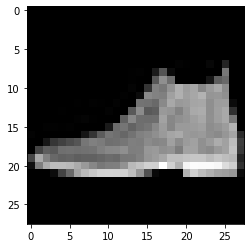

In [19]:
img_clean = input_tensor.cpu().numpy()
plt.imshow(img_clean[0,0],cmap='gray')

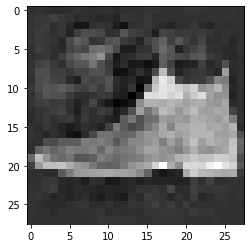

In [20]:
plt.imshow(adversarial_img[0,0],cmap='gray')